In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, DC_COLOR_MAPPINGS, FREQ_GROUPS
from cli import get_file_paths

import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh
import plotting
import pipeline

# Observation: The activity index is extremely reliant on the arbitrarily chosen time block

## Reasons include:
#### 1) Saturation: The maximum possible activity index for any interval is the total # of time blocks that fit in that interval. For a 30-min interval and a time block of 5-secs, the maximum activity index is 360.
#### 2) Quantization: The set of possible indices are always [0, 1, 2, ..., max.]. This offers us poor resolution when comparing activities as we are only allowed to view differences of 1.

### Both of these reasons combined mean that when the time block is relatively high (so the maximum value will be relatively low), the quanitization makes it so we have relatively few activity index differences per night.

### For example, if time block is 1-min, and the interval length is 30-min. The maximum activity index for an interval is 30. 

#### With a better metric, this would not be much of a problem if the resolution we had access to was in the 0.01. So indices can be in the set of [0, 0.01, 0.02, ... 30]. This would still provide us 3000 possible indices to assign. However, because the activity index is quantized for 1, we only have 30 possible indices to assign any activity. With this, there is a higher chance that many different activities are misassigned to 1 index.

In [4]:
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = False
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = False
pipeline_params["save_presence_grid"] = False
pipeline_params["save_dc_night_comparisons"] = False
pipeline_params["save_activity_dc_comparisons"] = False
pipeline_params["save_presence_dc_comparisons"] = False
pipeline_params["show_plots"] = True
pipeline_params["show_PST"] = True

data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['data_resolution_in_min'] = '720'

time_blocks = ['5', '60', '300', '600']

In [5]:
def construct_activity_arr_from_bout_metrics(bout_metrics, data_params, file_paths, dc_tag):

    first_call_time = bout_metrics.resample(f'{data_params["data_resolution_in_min"]}T', on='start_time_of_bout', origin='start')['start_time_of_bout'].count().index[0]
    start_of_recording = pd.Timedelta(f"{data_params['recording_start']}:00")
    offset_time = pd.Timedelta(f'{((first_call_time - start_of_recording).time())}') * -1

    all_processed_filepaths = sorted(list(map(str, list(Path(f'{file_paths["raw_SITE_folder"]}').glob('*.csv')))))
    all_processed_datetimes = pd.to_datetime(all_processed_filepaths, format="%Y%m%d_%H%M%S", exact=False)

    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bout_metrics['total_bout_duration_in_secs'] = bout_metrics['bout_duration_in_secs']
    bout_metrics = bout_metrics.set_index('ref_time')

    bout_duration_per_interval = bout_metrics.resample(f"{data_params['data_resolution_in_min']}T", origin='start', offset=offset_time)['total_bout_duration_in_secs'].sum()

    time_occupied_by_bouts  = bout_duration_per_interval.values
    percent_time_occupied_by_bouts = (100*(time_occupied_by_bouts / (60*float(data_params['data_resolution_in_min']))))
    test_bout_percentages_less_than_100(percent_time_occupied_by_bouts)

    bout_duration_per_interval.index = bout_duration_per_interval.index.round('30T')
    bout_dpi_df = pd.DataFrame(list(zip(bout_duration_per_interval.index, percent_time_occupied_by_bouts)), columns=['ref_time', f'percentage_time_occupied_by_bouts ({dc_tag})'])
    bout_dpi_df = bout_dpi_df.set_index('ref_time')
    bout_dpi_df = bout_dpi_df.reindex(index=all_processed_datetimes, fill_value=0)
    bout_dpi_df = bout_dpi_df.resample(f"{data_params['data_resolution_in_min']}T", origin='start').first()
    bout_dpi_df = bout_dpi_df.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    return pd.DataFrame(list(zip(bout_dpi_df.index, bout_dpi_df[f'percentage_time_occupied_by_bouts ({dc_tag})'].values)), columns=["Date_and_Time_UTC", f'percentage_time_occupied_by_bouts ({dc_tag})'])

def test_bout_percentages_less_than_100(percent_time_occupied_by_bouts):
    assert(percent_time_occupied_by_bouts.max() <= 100)

def construct_activity_indices_arr(location_df, dc_tag, file_paths, data_params):

    first_call_time = location_df.resample(f'{data_params["index_time_block_in_secs"]}S', on='call_start_time')['call_start_time'].count().index[0]
    start_of_recording = pd.Timedelta(f"{data_params['recording_start']}:00")
    offset_time = pd.Timedelta(f'{((first_call_time - start_of_recording).time())}') * -1

    temp = location_df.resample(f'{data_params["index_time_block_in_secs"]}S', on='call_start_time')['call_start_time'].count()
    temp[temp>0] = 1
    activity_indices = temp.resample(f"{data_params['data_resolution_in_min']}T", origin='start', offset=offset_time).sum()
    test_activity_indices_less_than_max(activity_indices.values, data_params)

    time_intervals = location_df.resample(f"{data_params['data_resolution_in_min']}T", on='ref_time', origin='start', offset=offset_time).first().index
    col_name = f"Activity Indices ({dc_tag})"
    incomplete_activity_arr = pd.DataFrame(activity_indices.values, index=activity_indices.index, columns=[col_name])

    all_processed_filepaths = sorted(list(map(str, list(Path(f'{file_paths["raw_SITE_folder"]}').glob('*.csv')))))
    all_processed_datetimes = pd.to_datetime(all_processed_filepaths, format="%Y%m%d_%H%M%S", exact=False)

    activity_arr = incomplete_activity_arr.reindex(index=all_processed_datetimes, fill_value=0)
    activity_arr = activity_arr.resample(f"{data_params['data_resolution_in_min']}T", origin='start').first()
    activity_arr = activity_arr.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    return pd.DataFrame(list(zip(activity_arr.index, activity_arr[col_name].values)), columns=["Date_and_Time_UTC", col_name])

def test_activity_indices_less_than_max(activity_indices, data_params):
    time_block_duration = int(data_params['index_time_block_in_secs'])
    peak_index = (60*int(data_params['data_resolution_in_min'])/time_block_duration)
    assert(activity_indices.max()<=peak_index)

Carp LF1


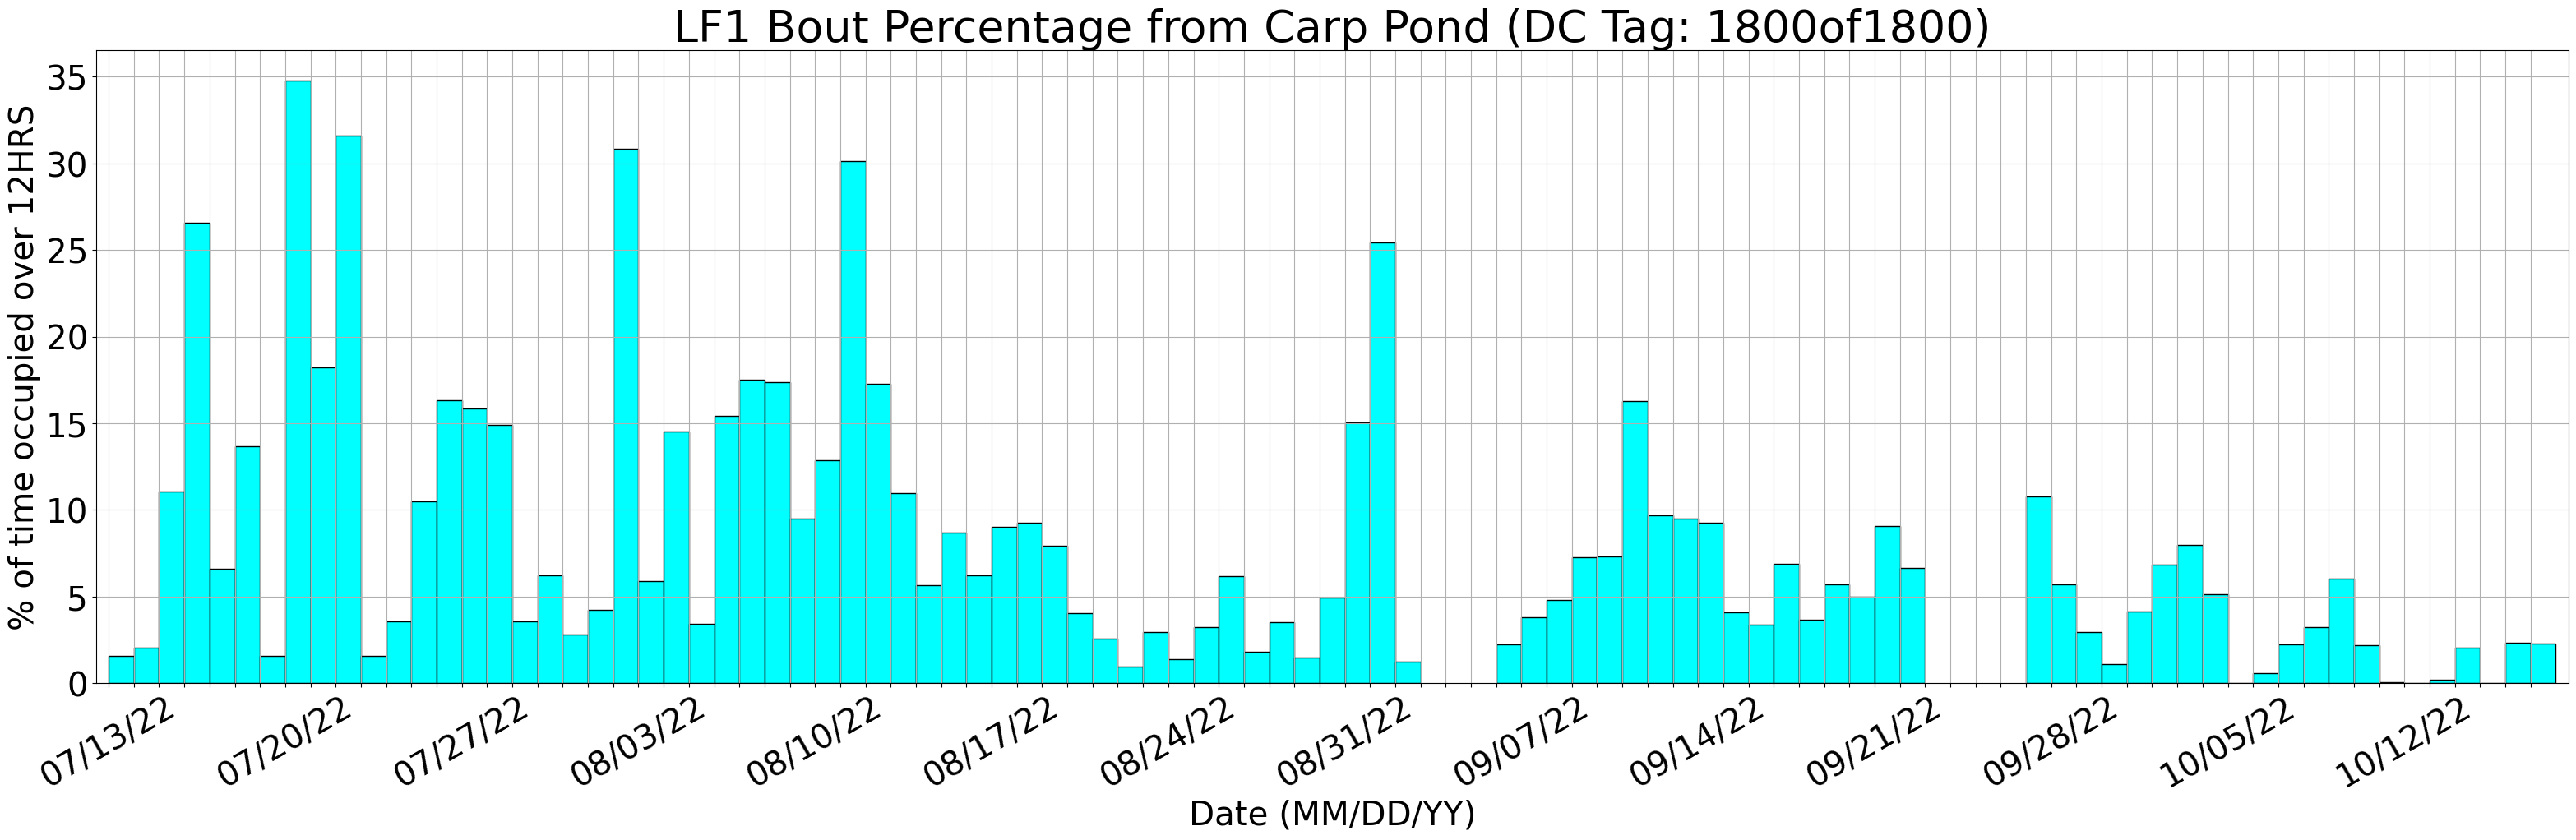

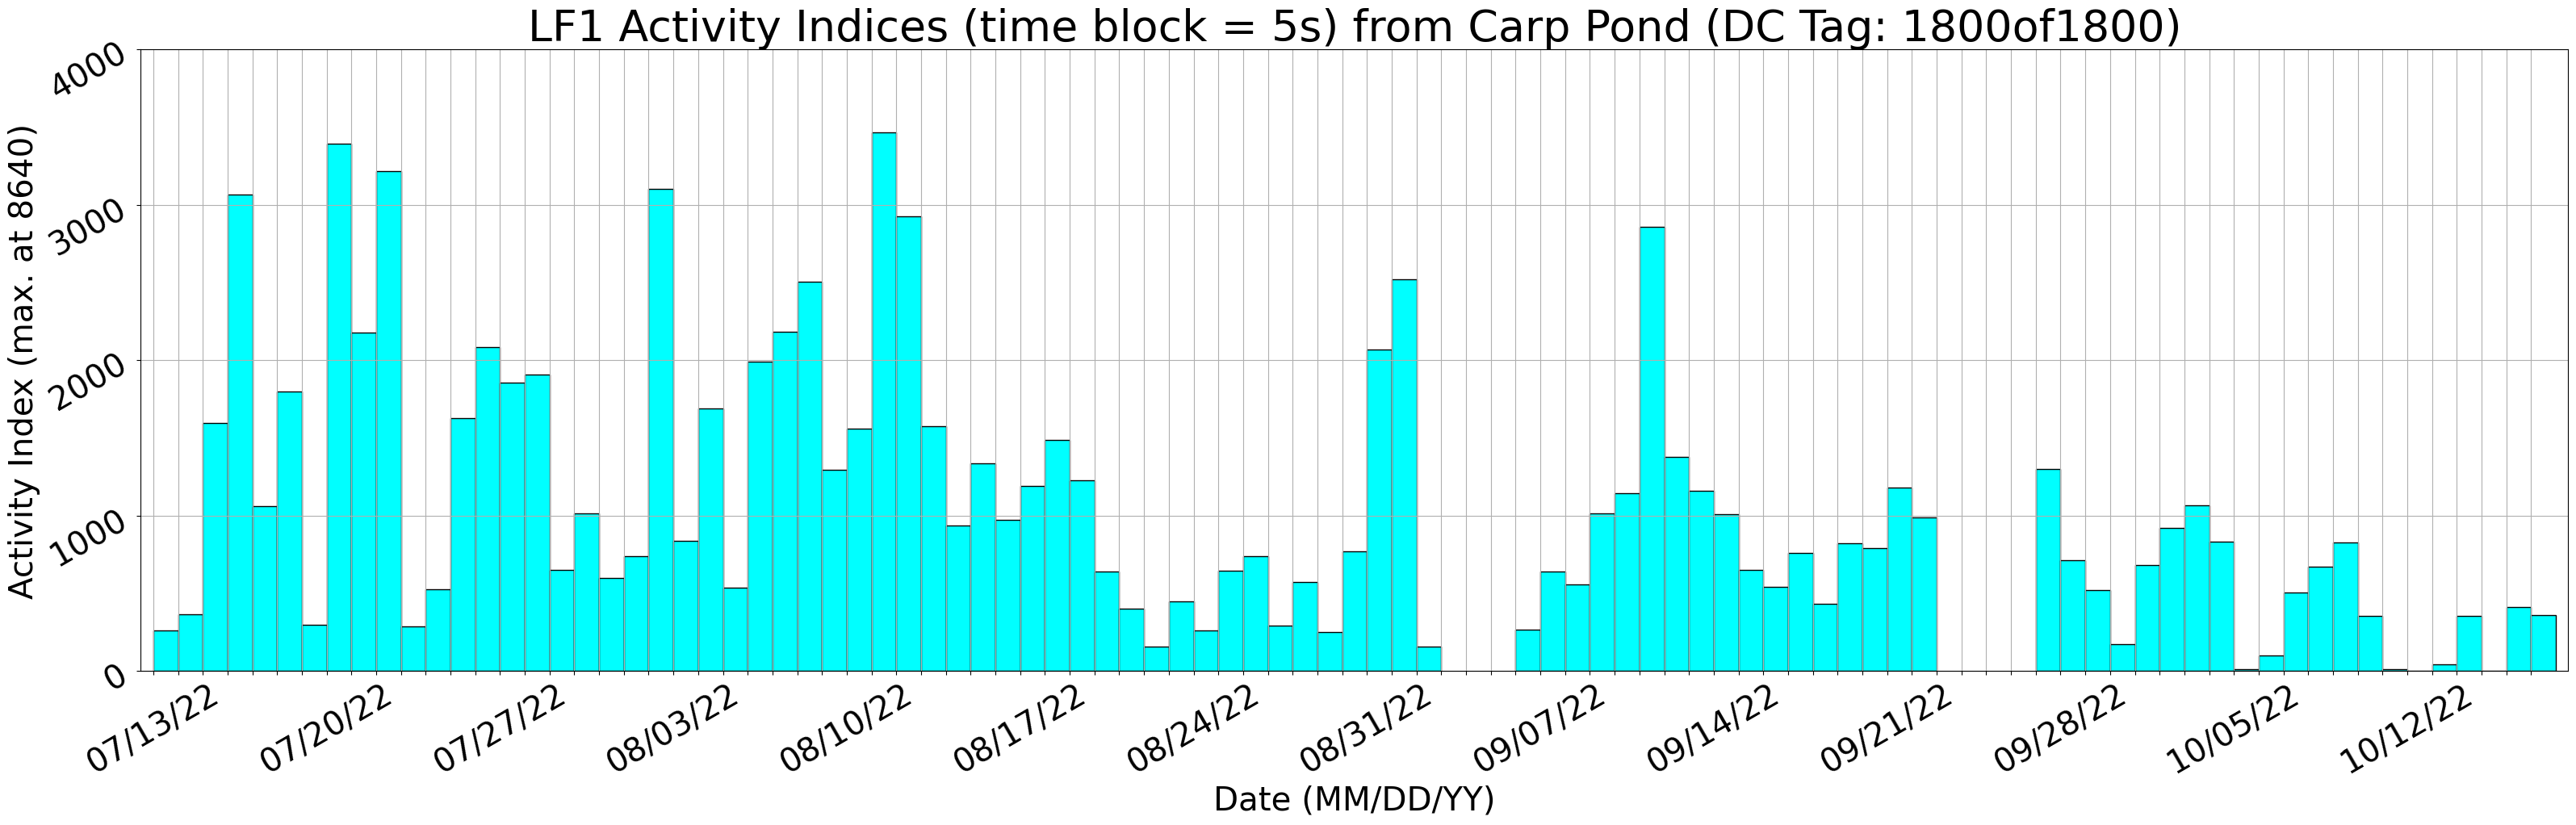

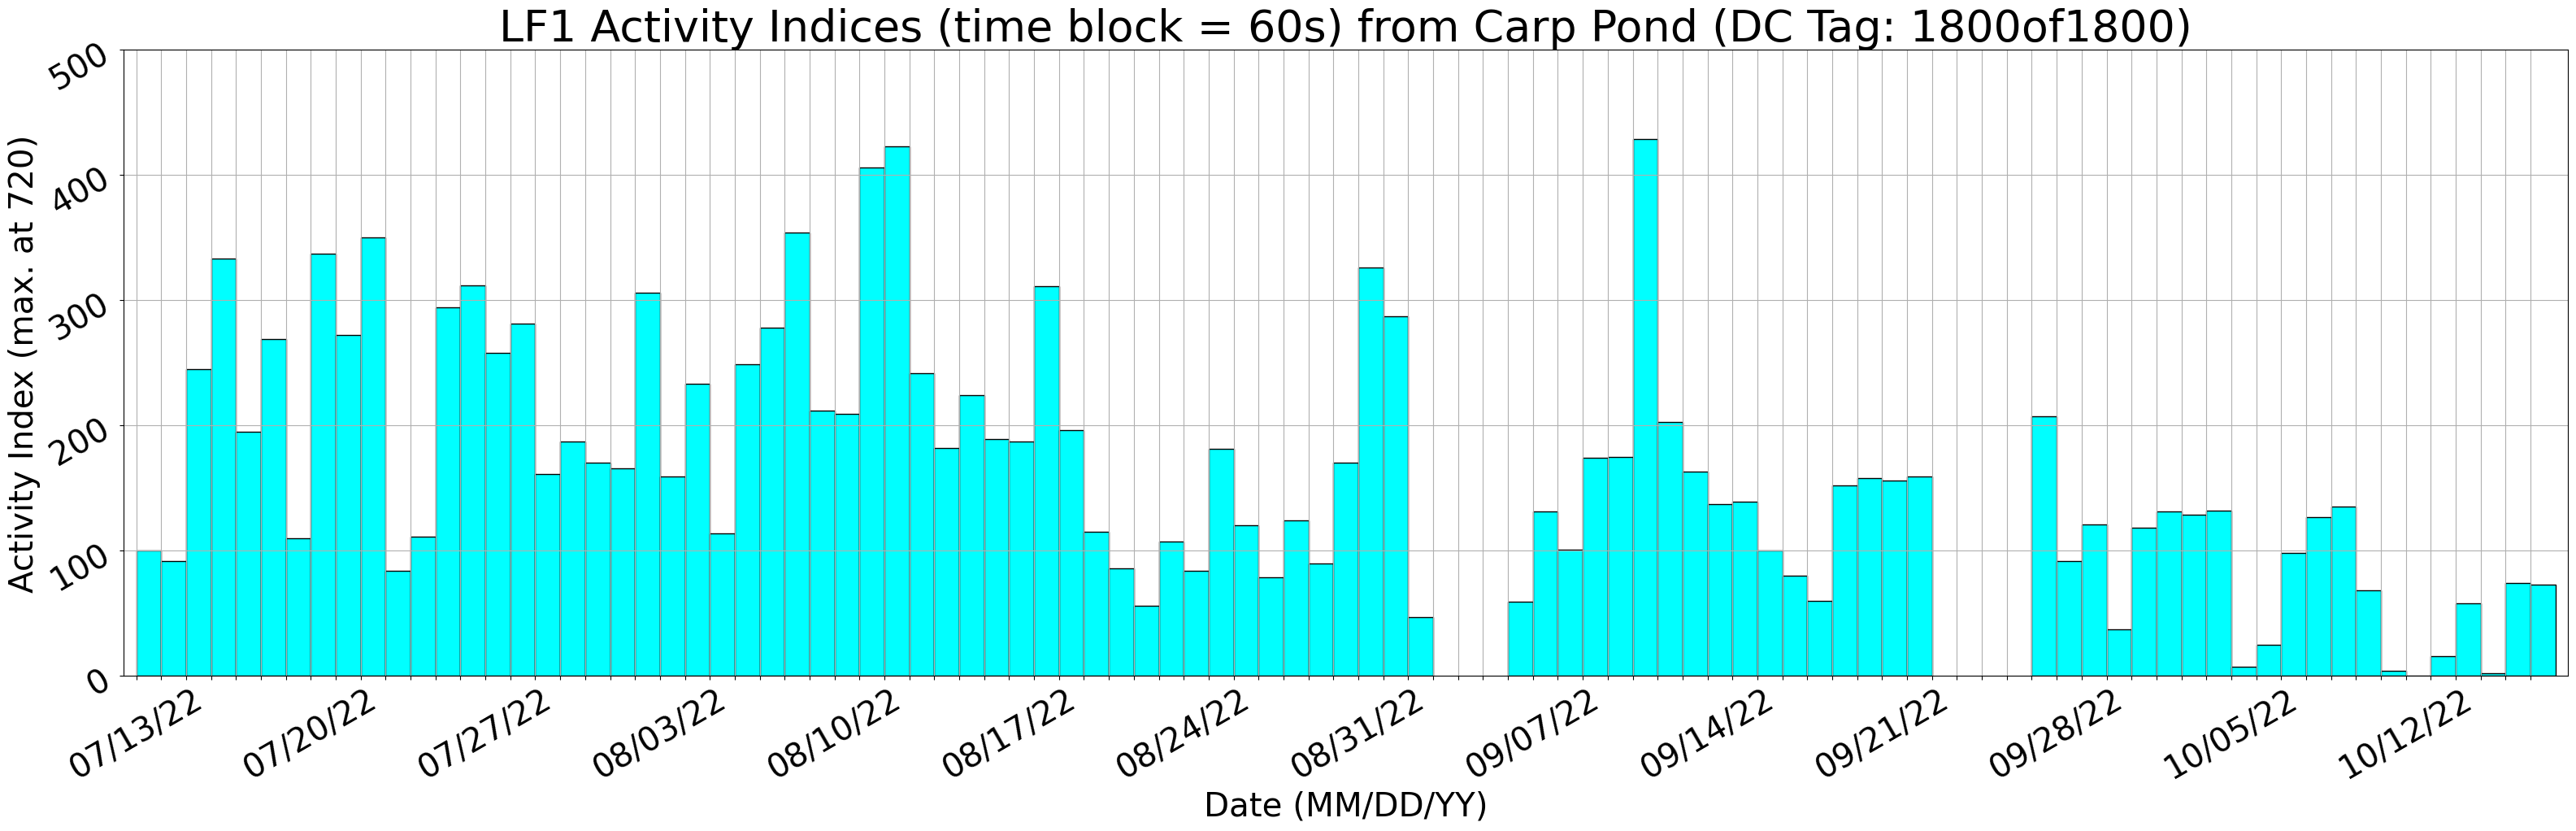

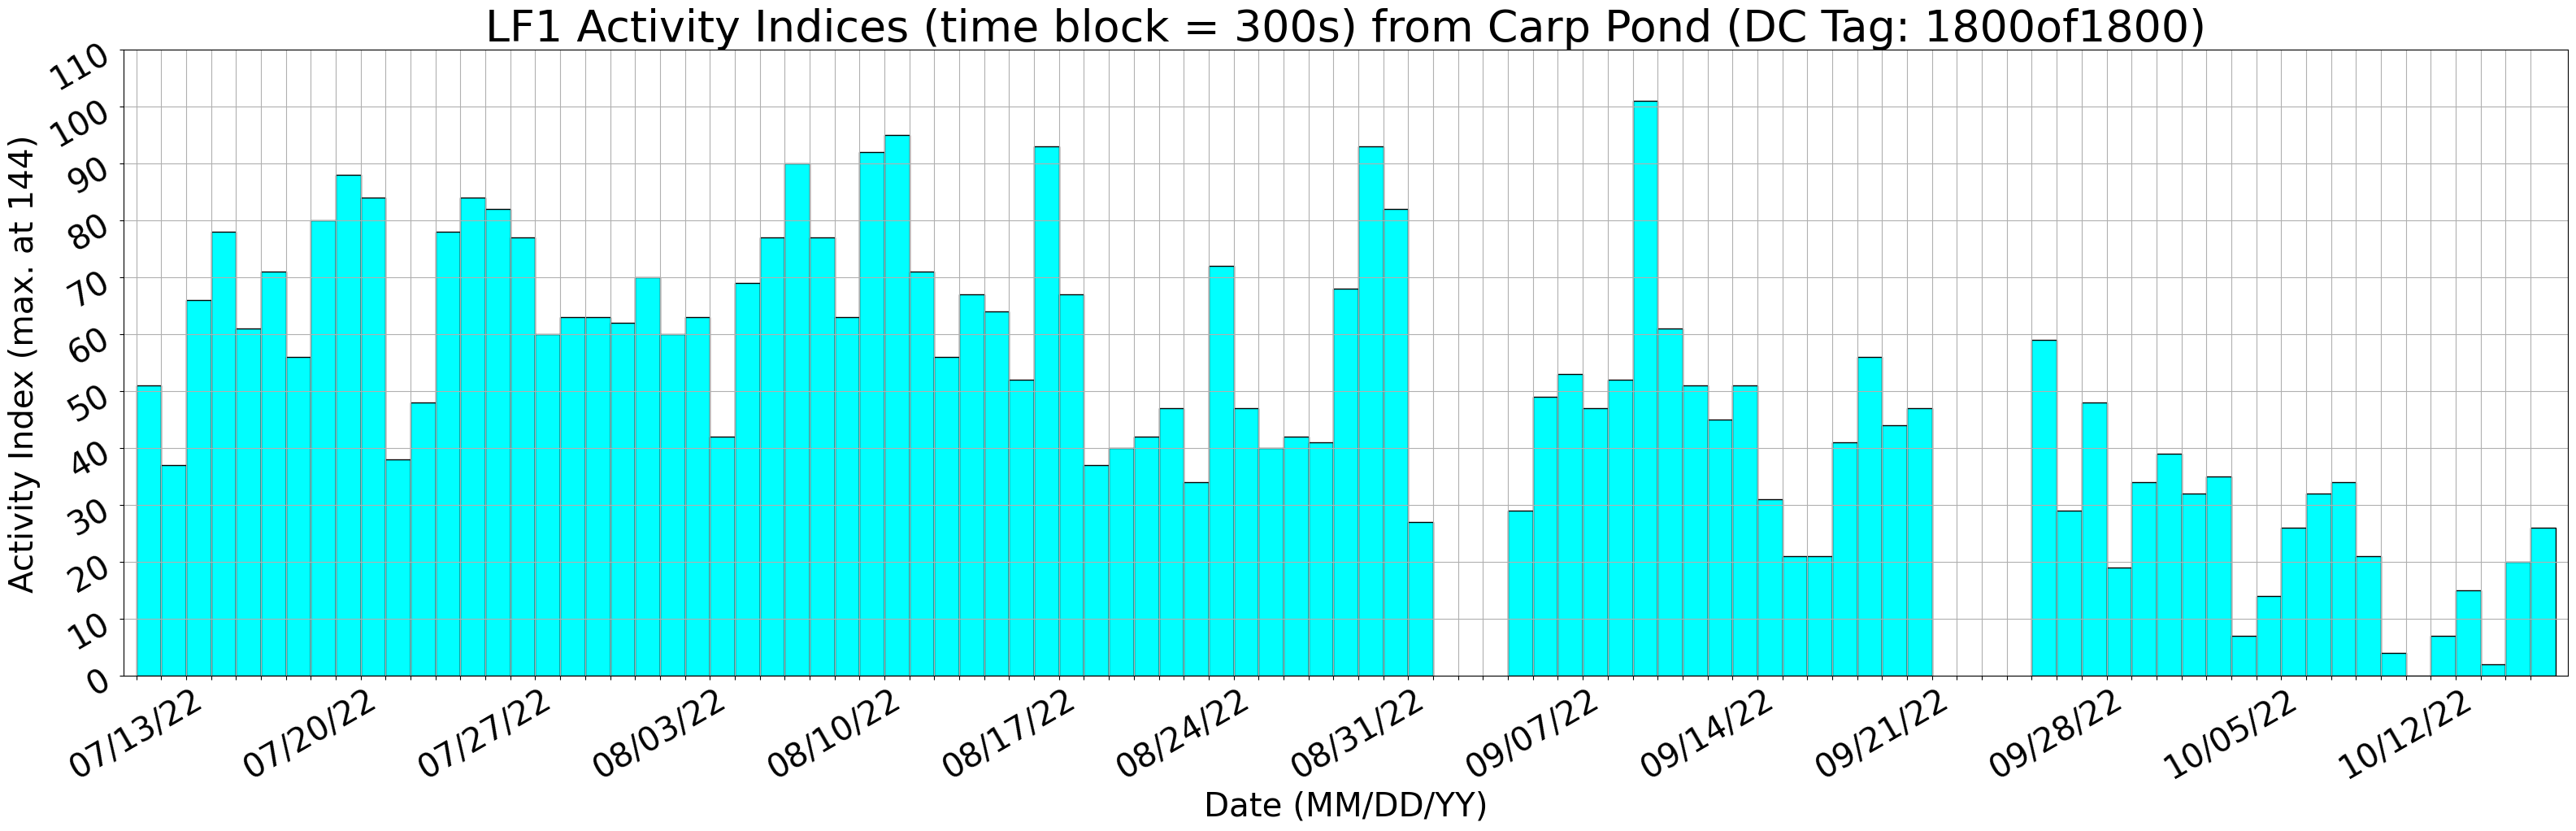

Carp HF1


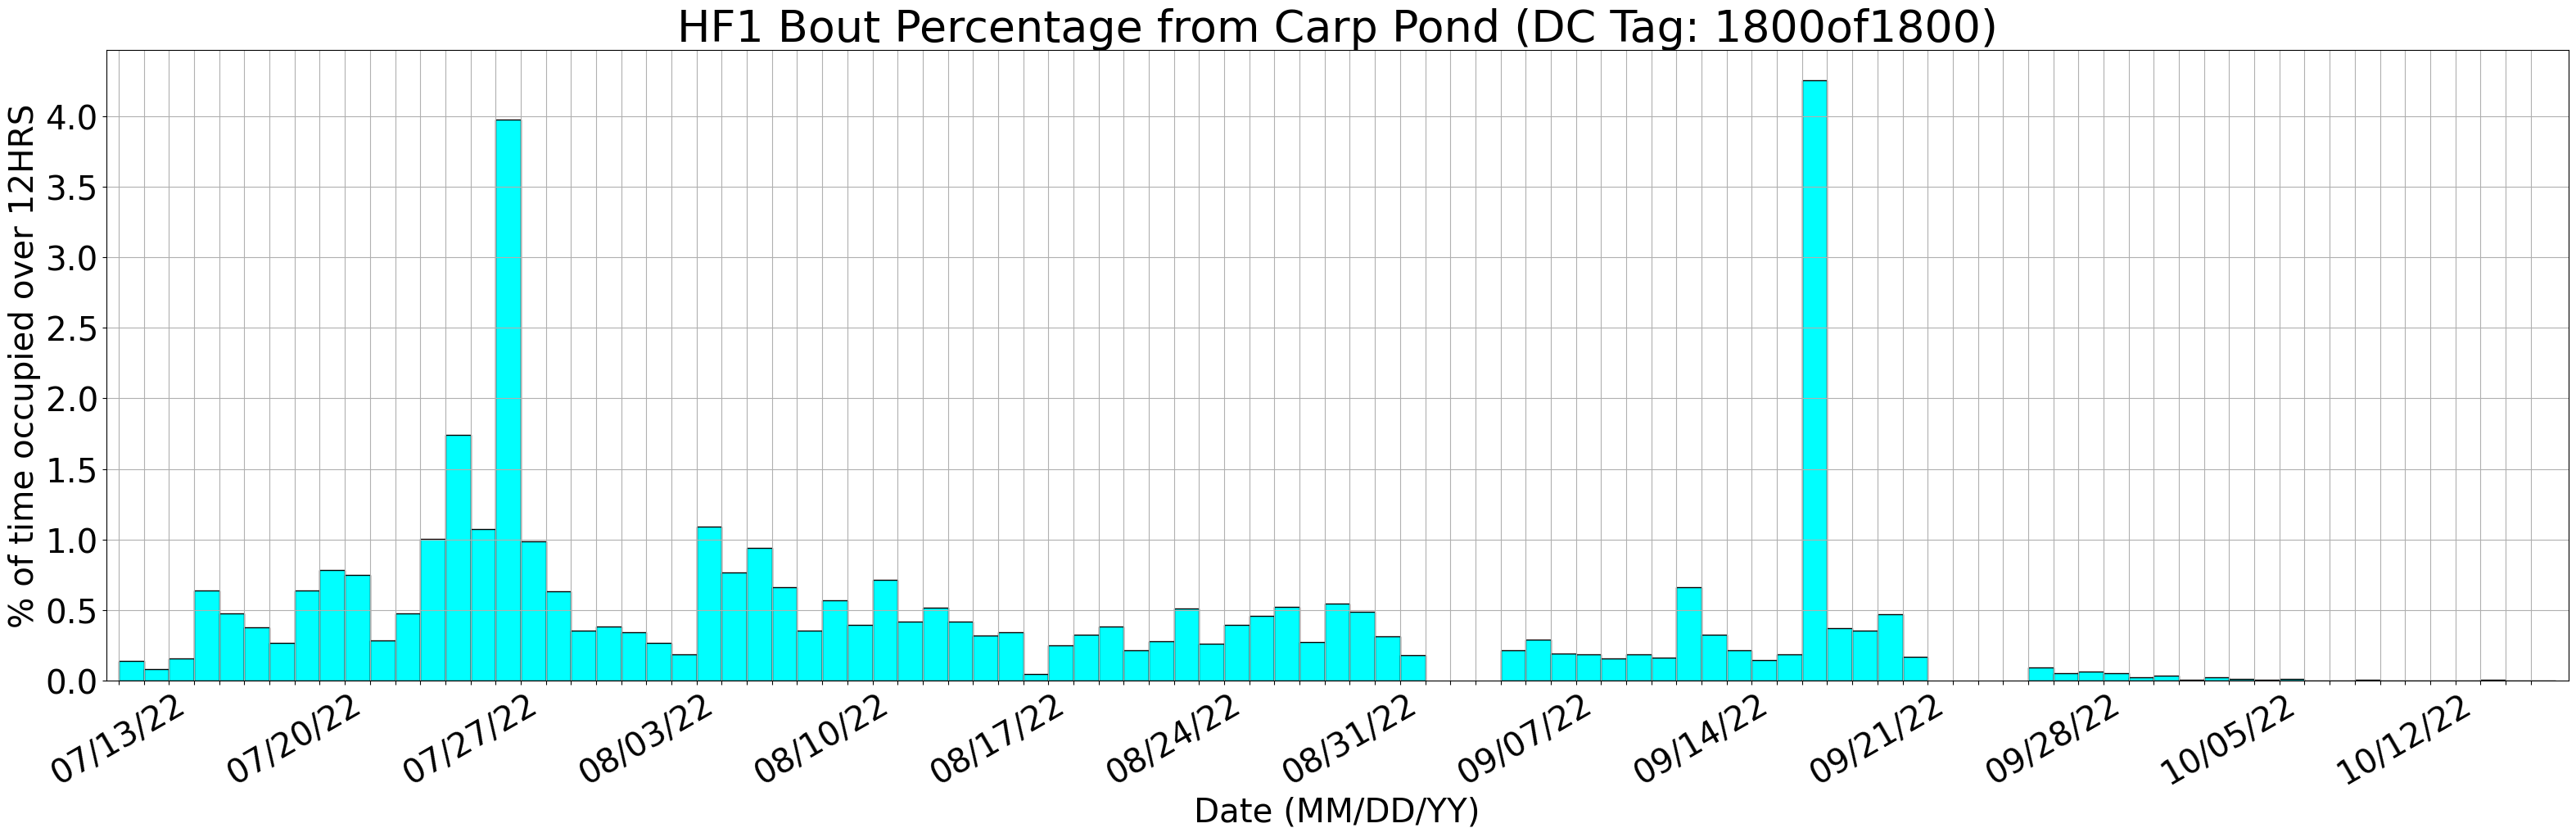

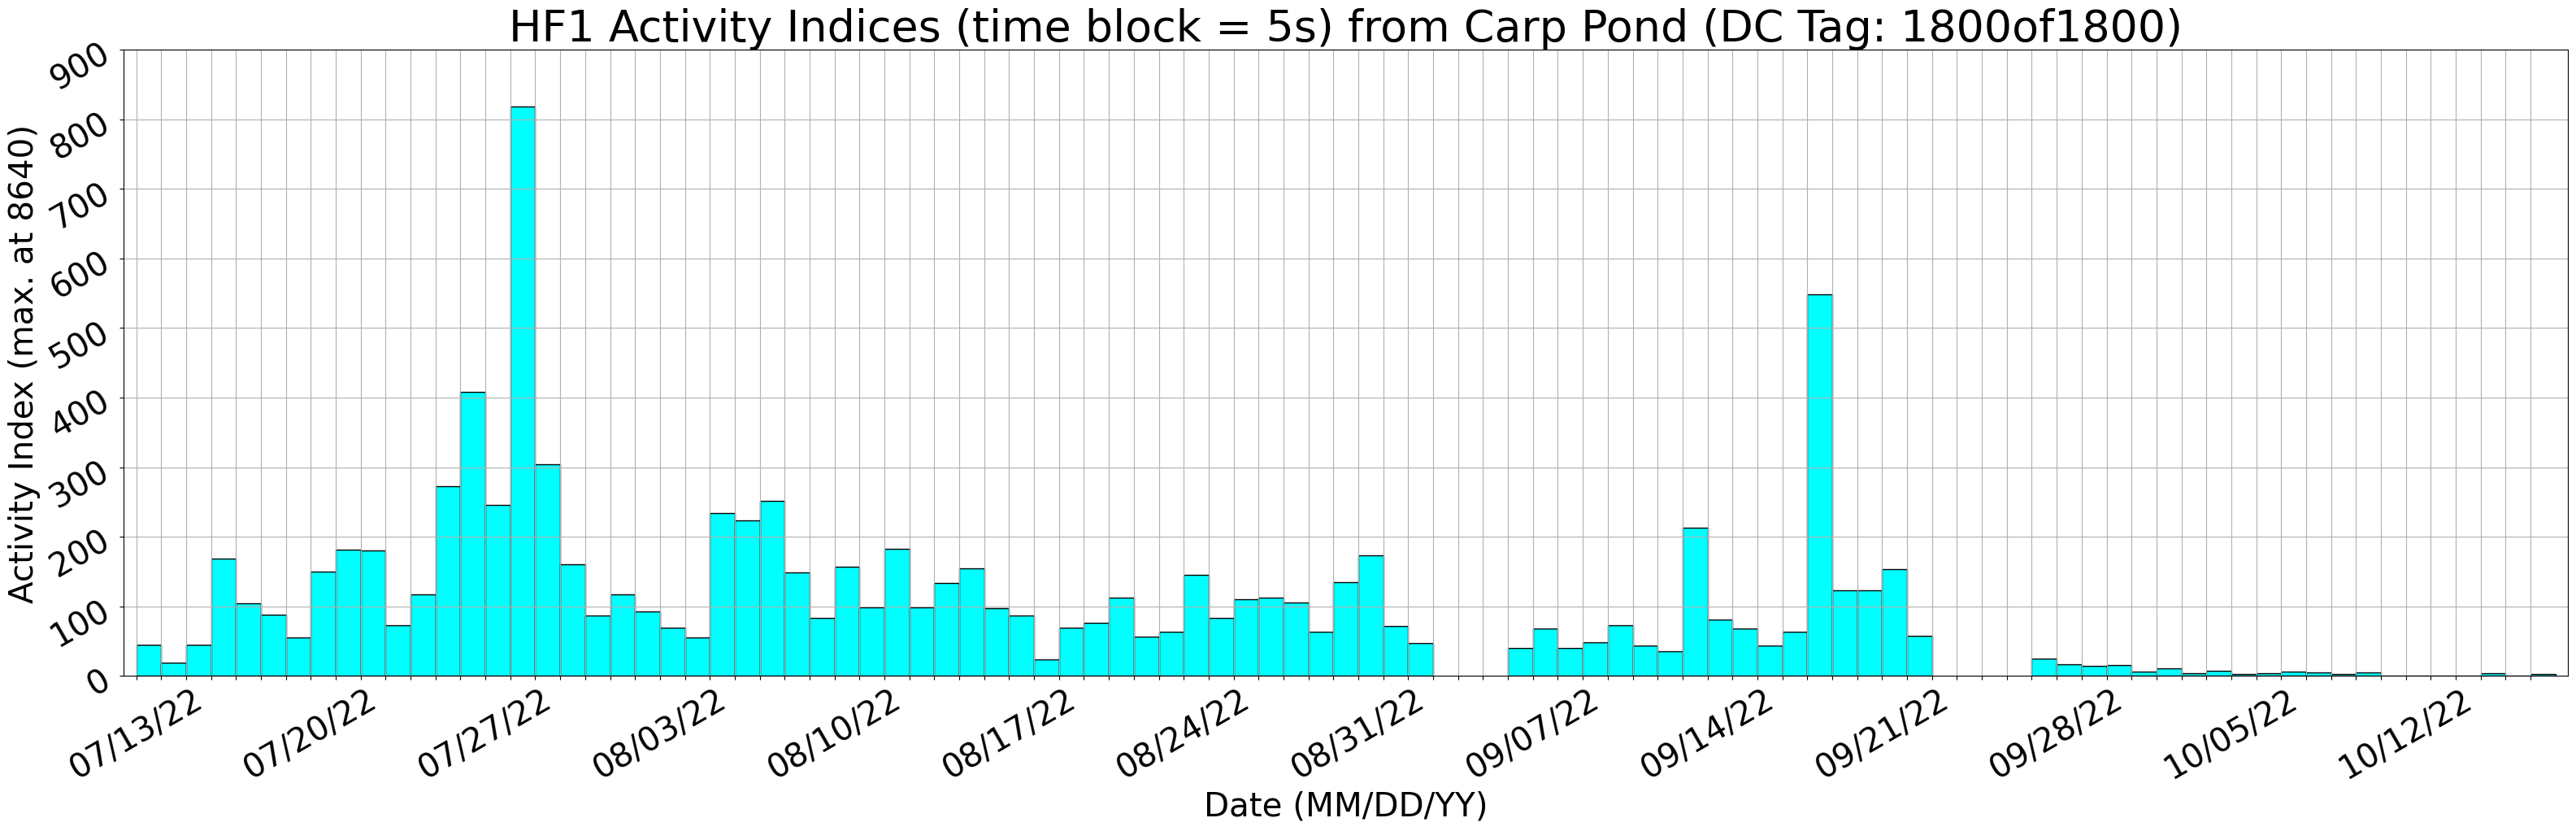

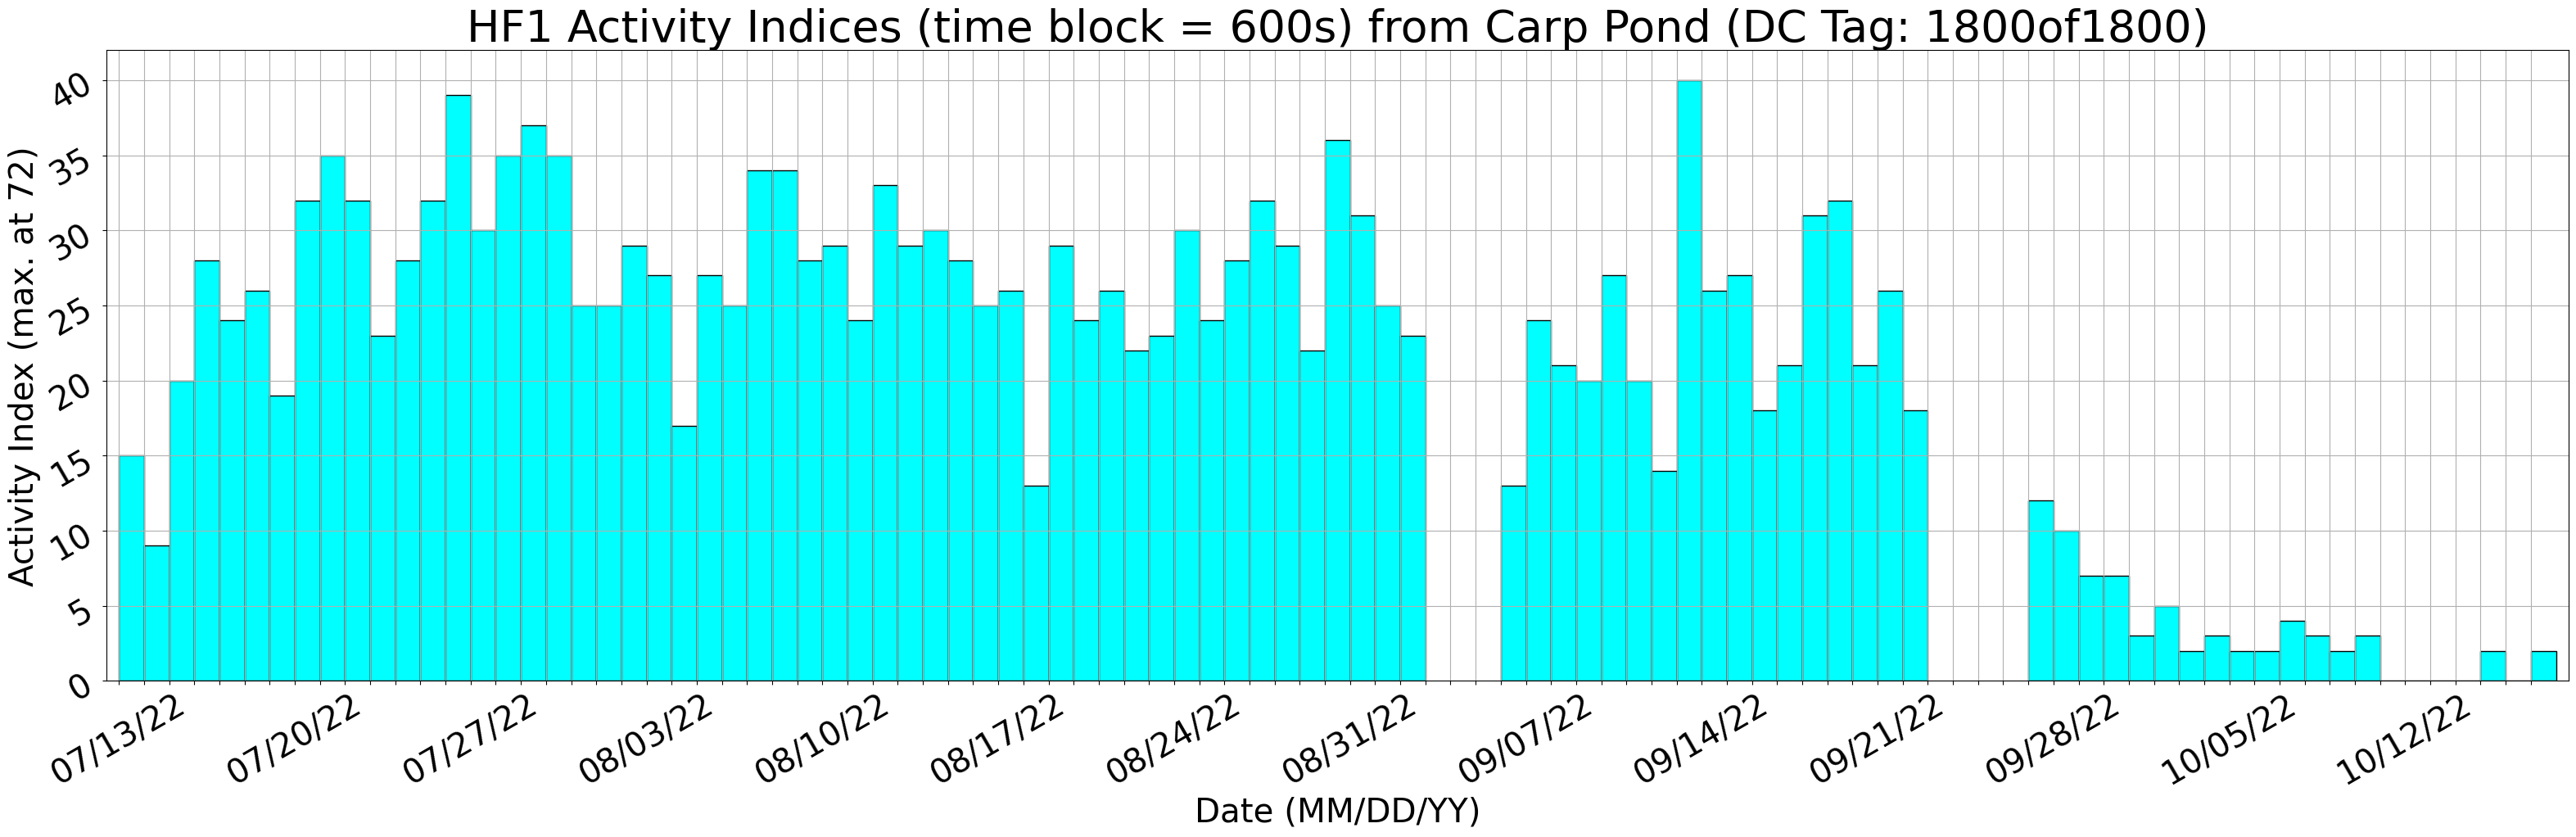

Carp HF2


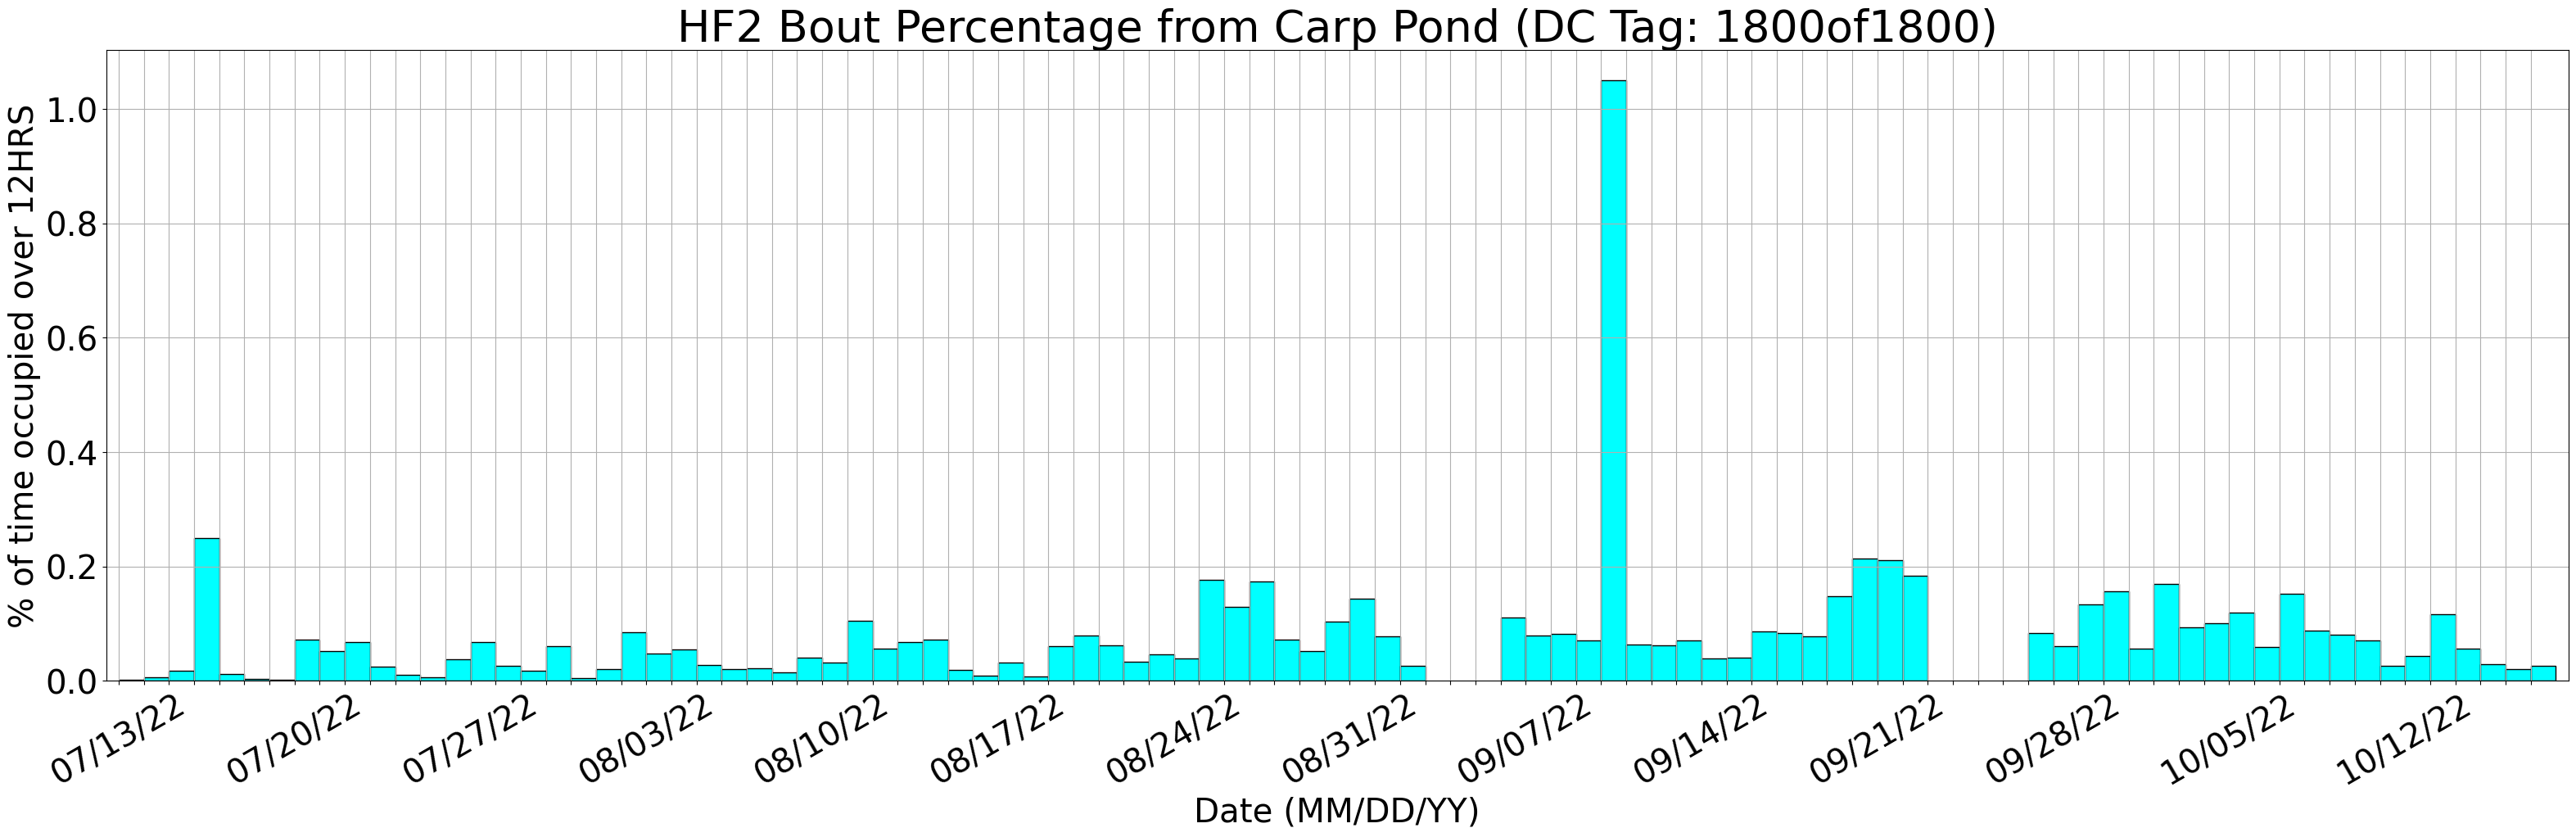

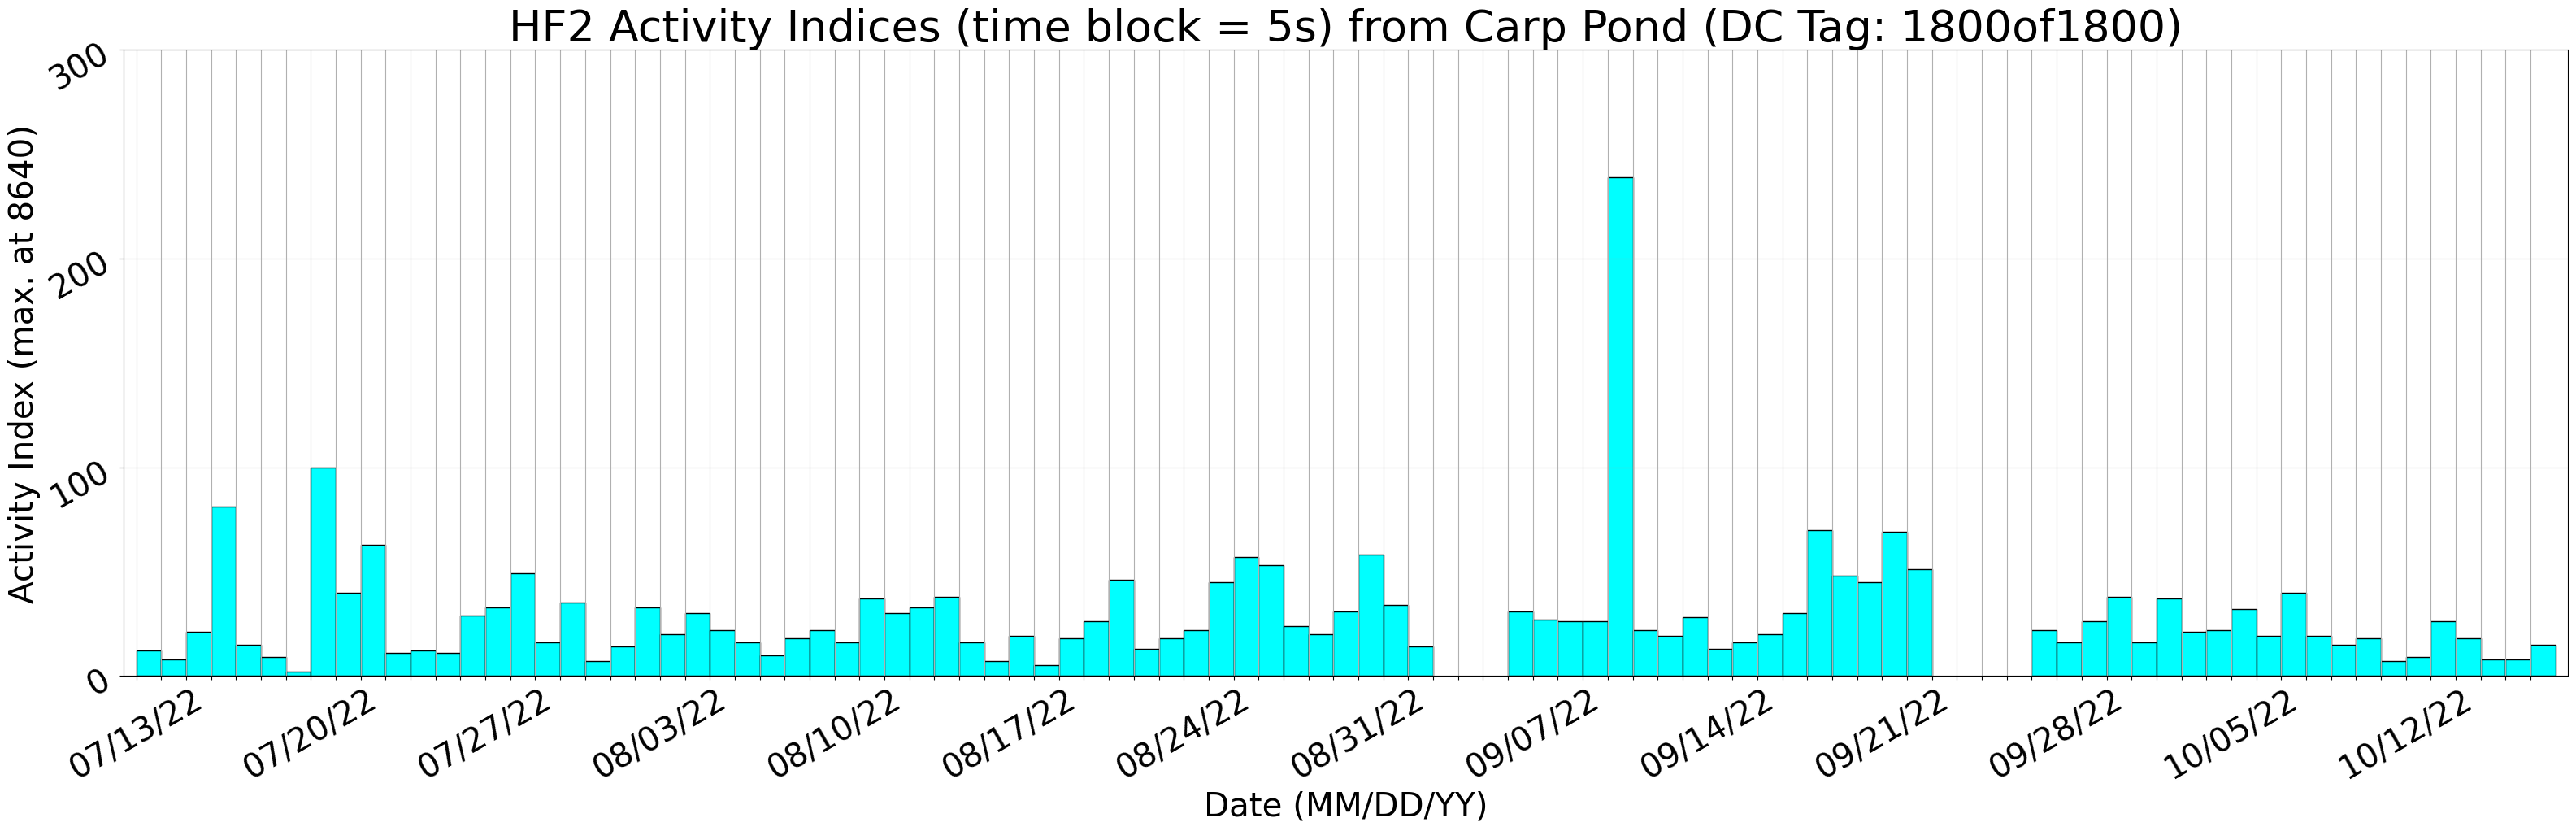

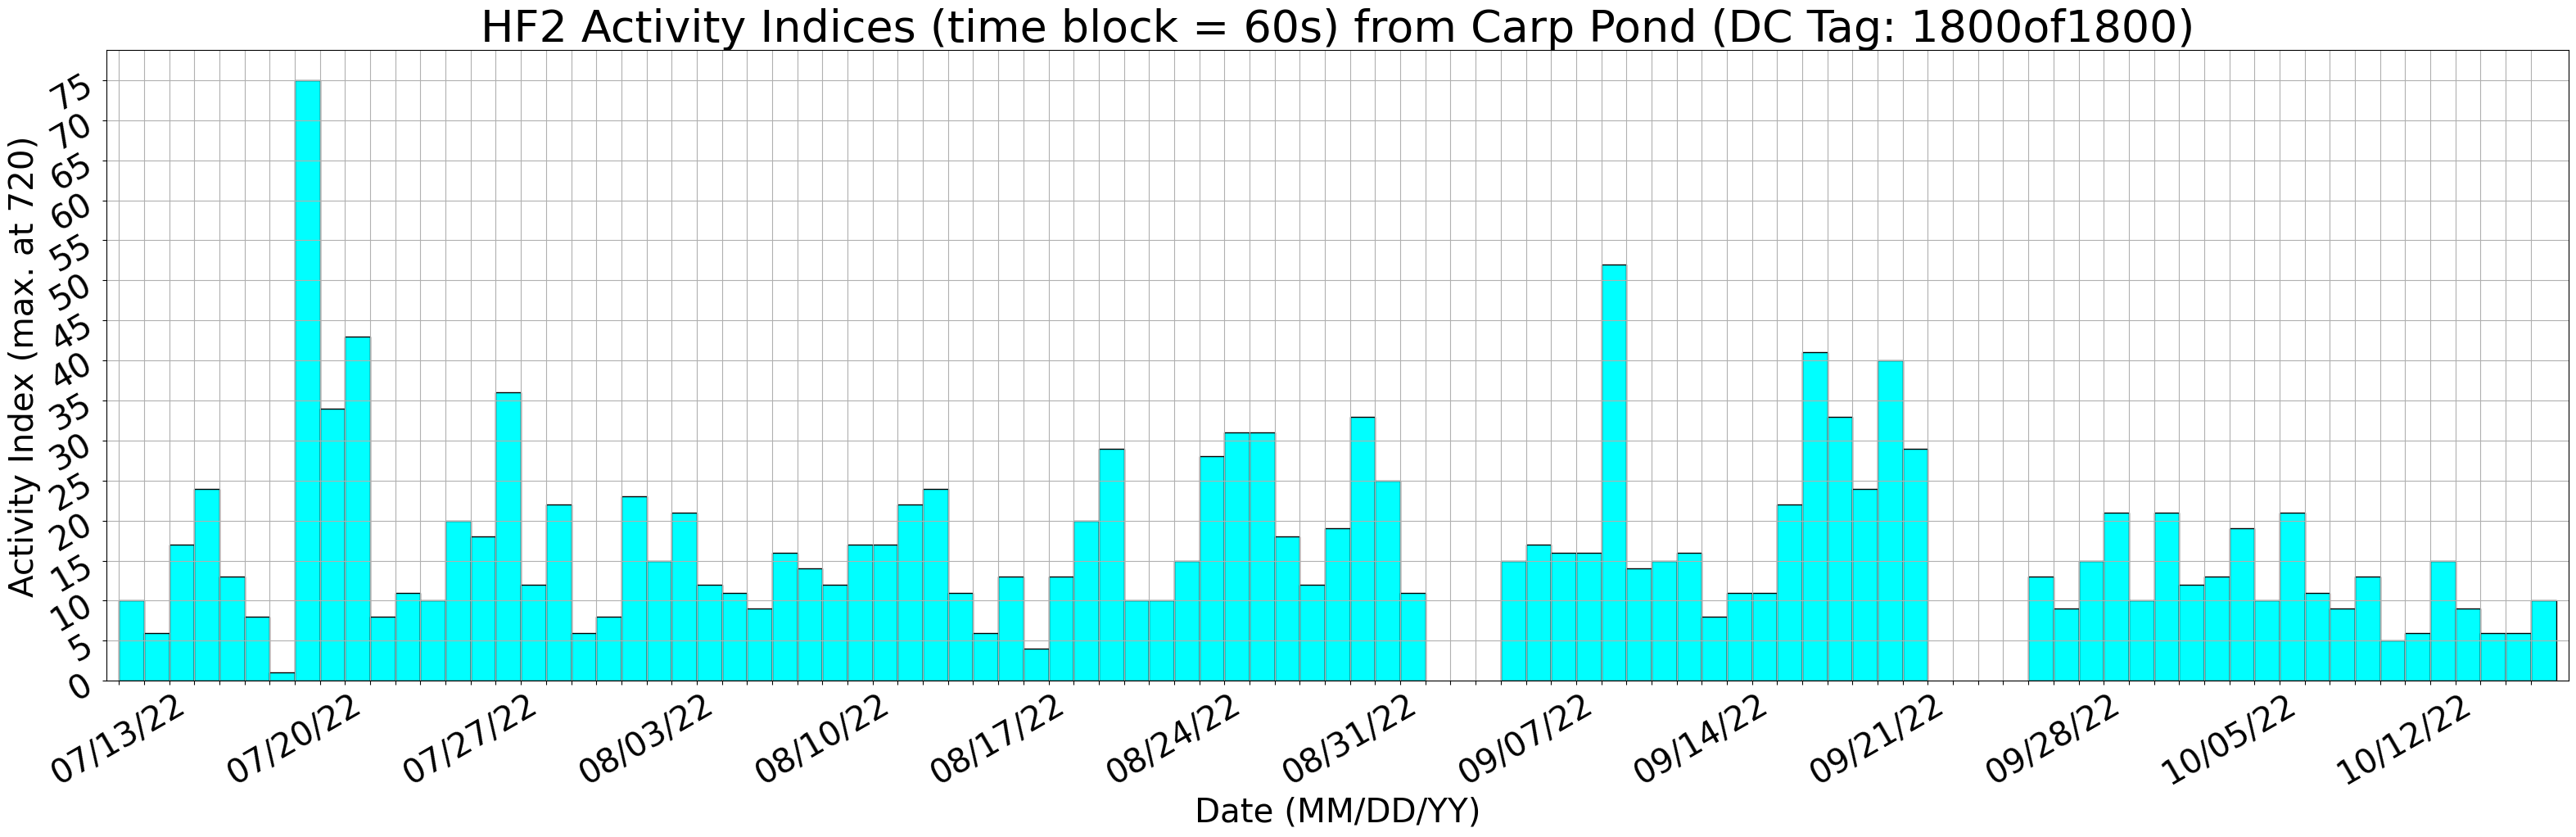

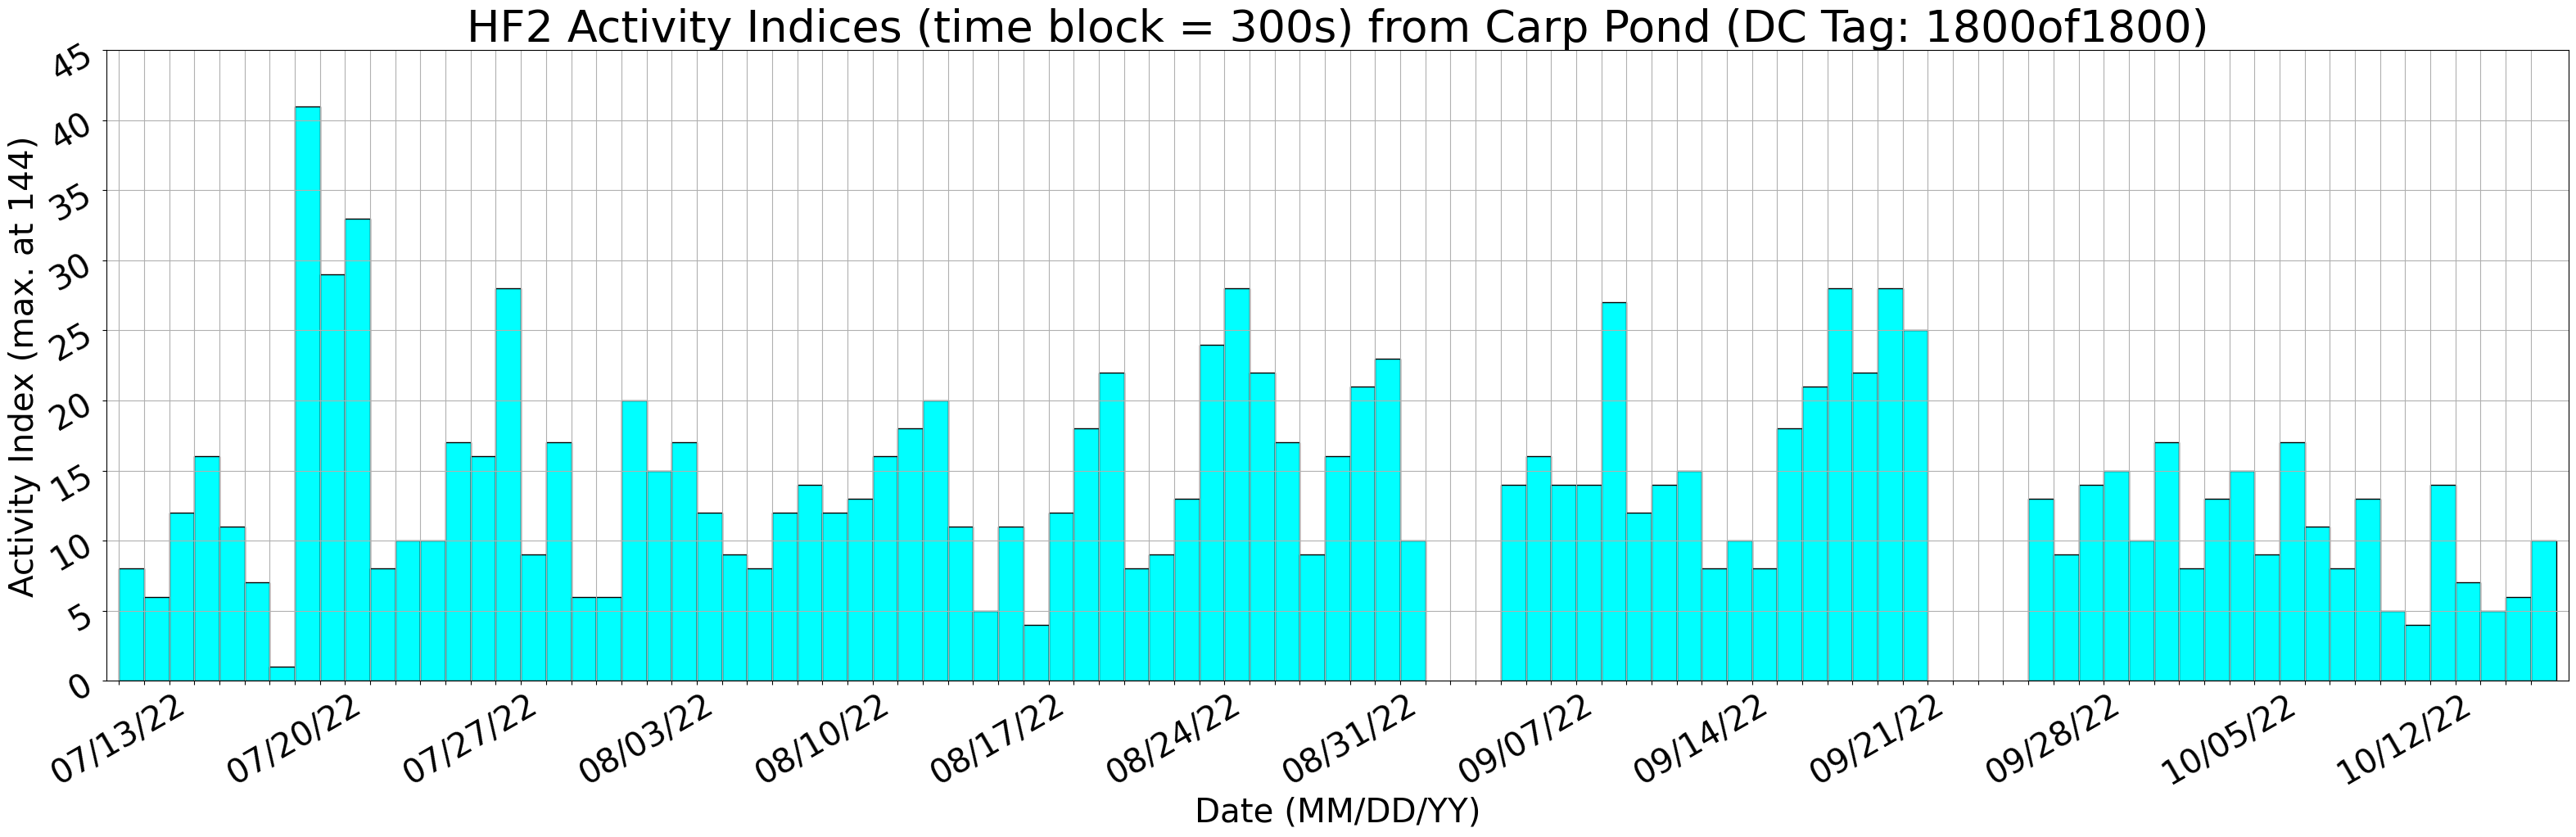

Foliage LF1


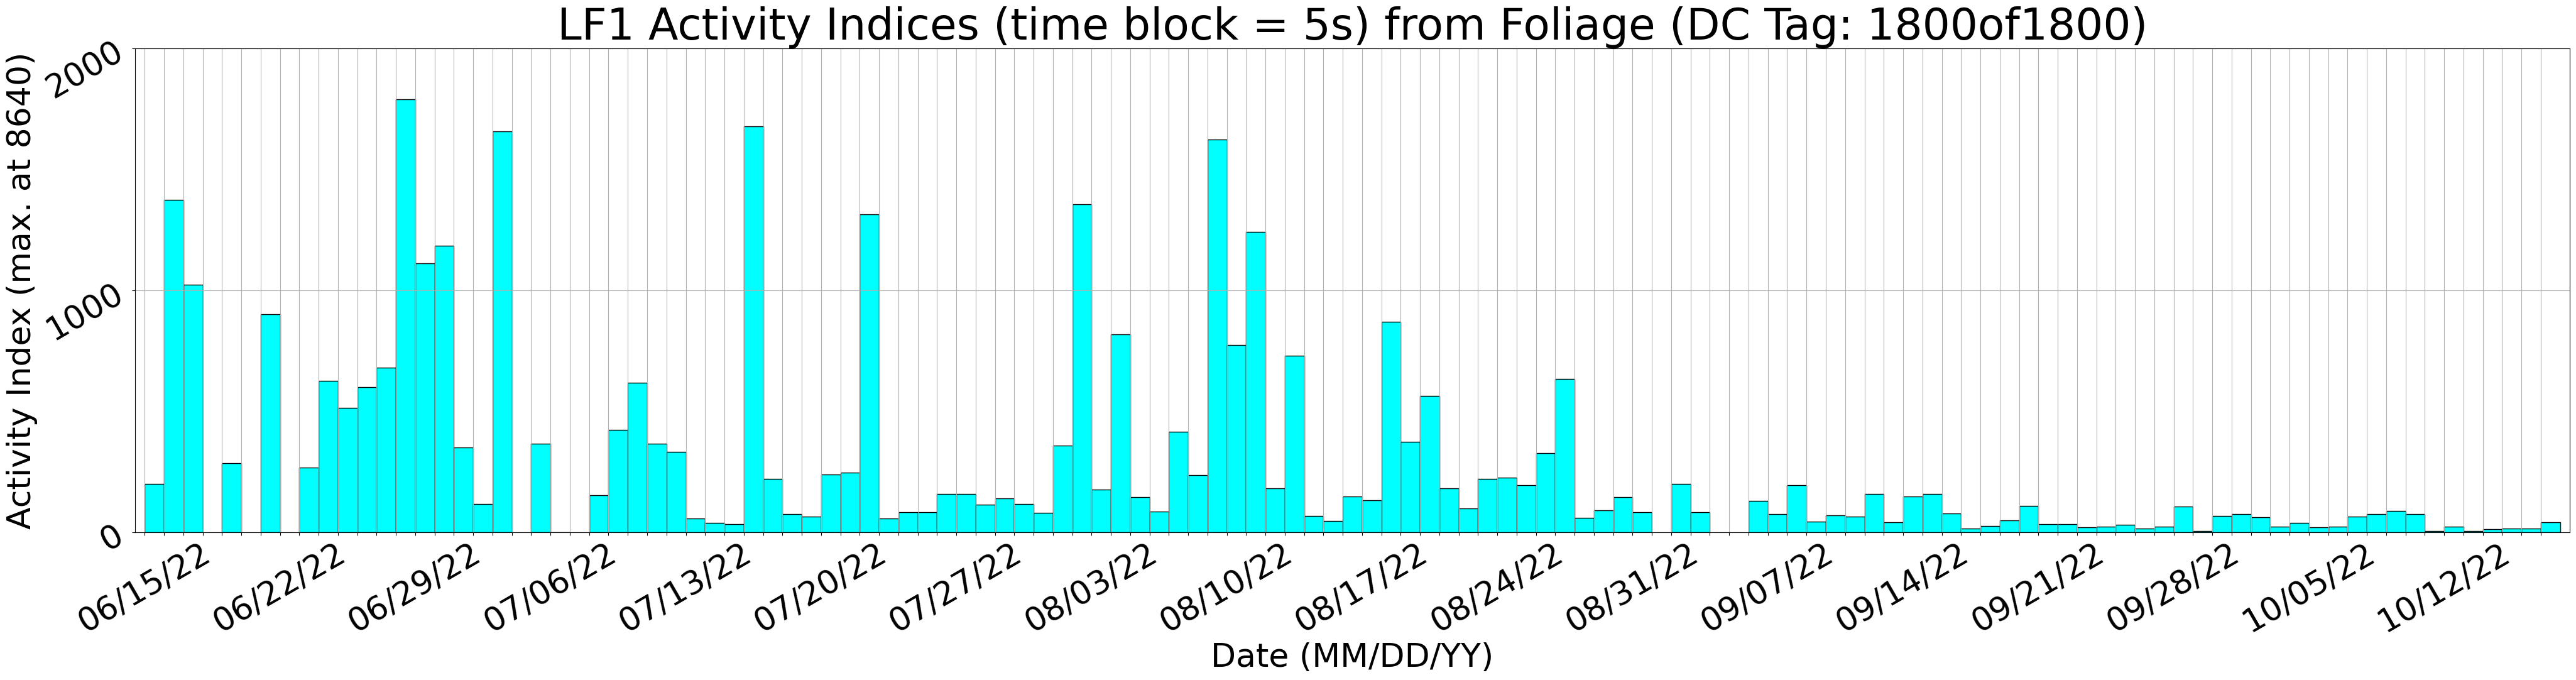

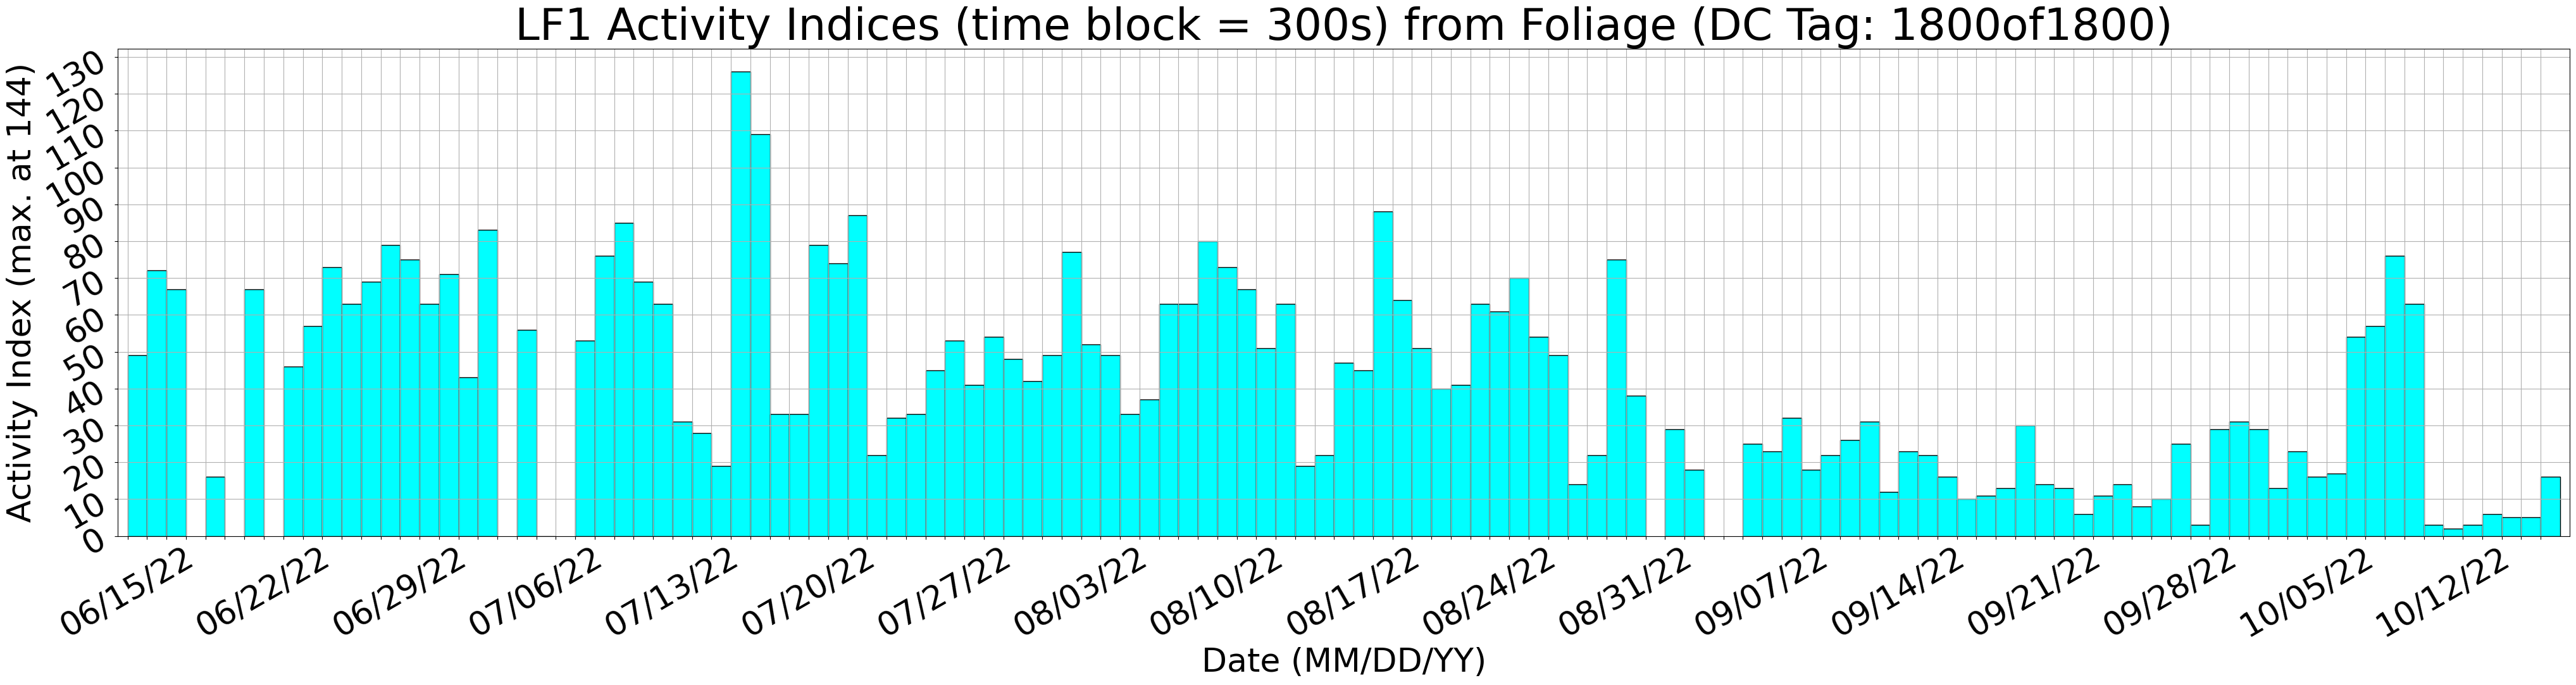

Foliage HF1


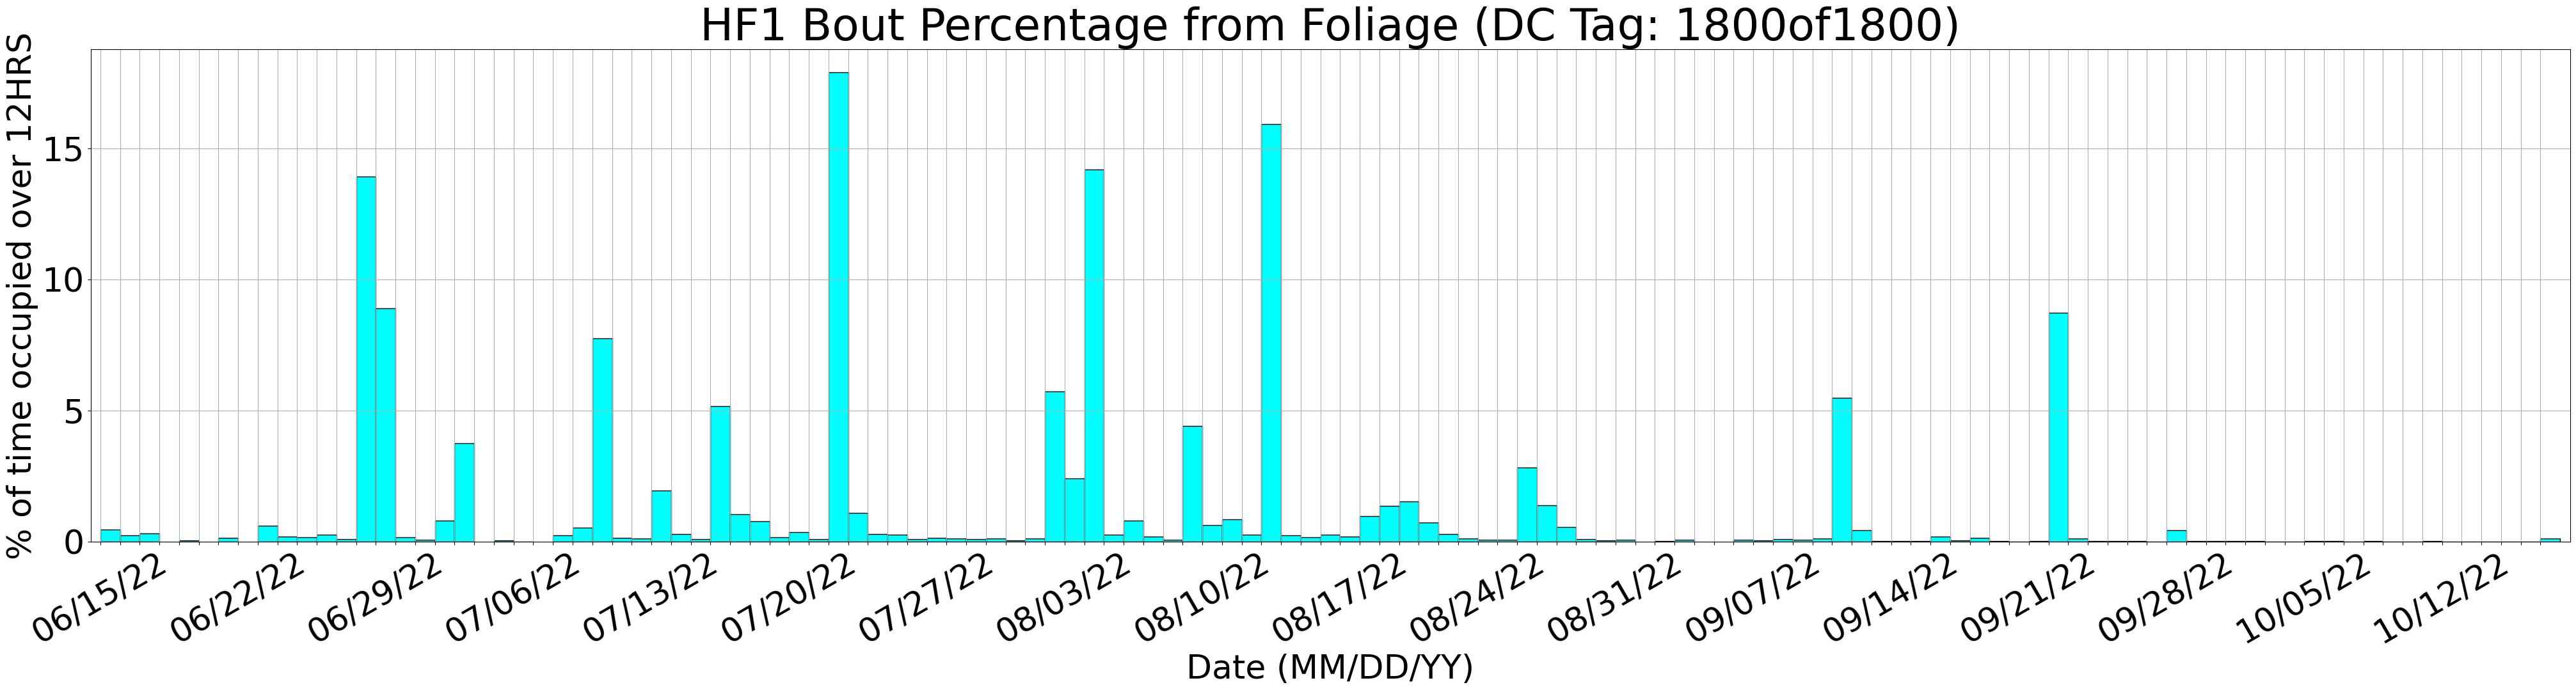

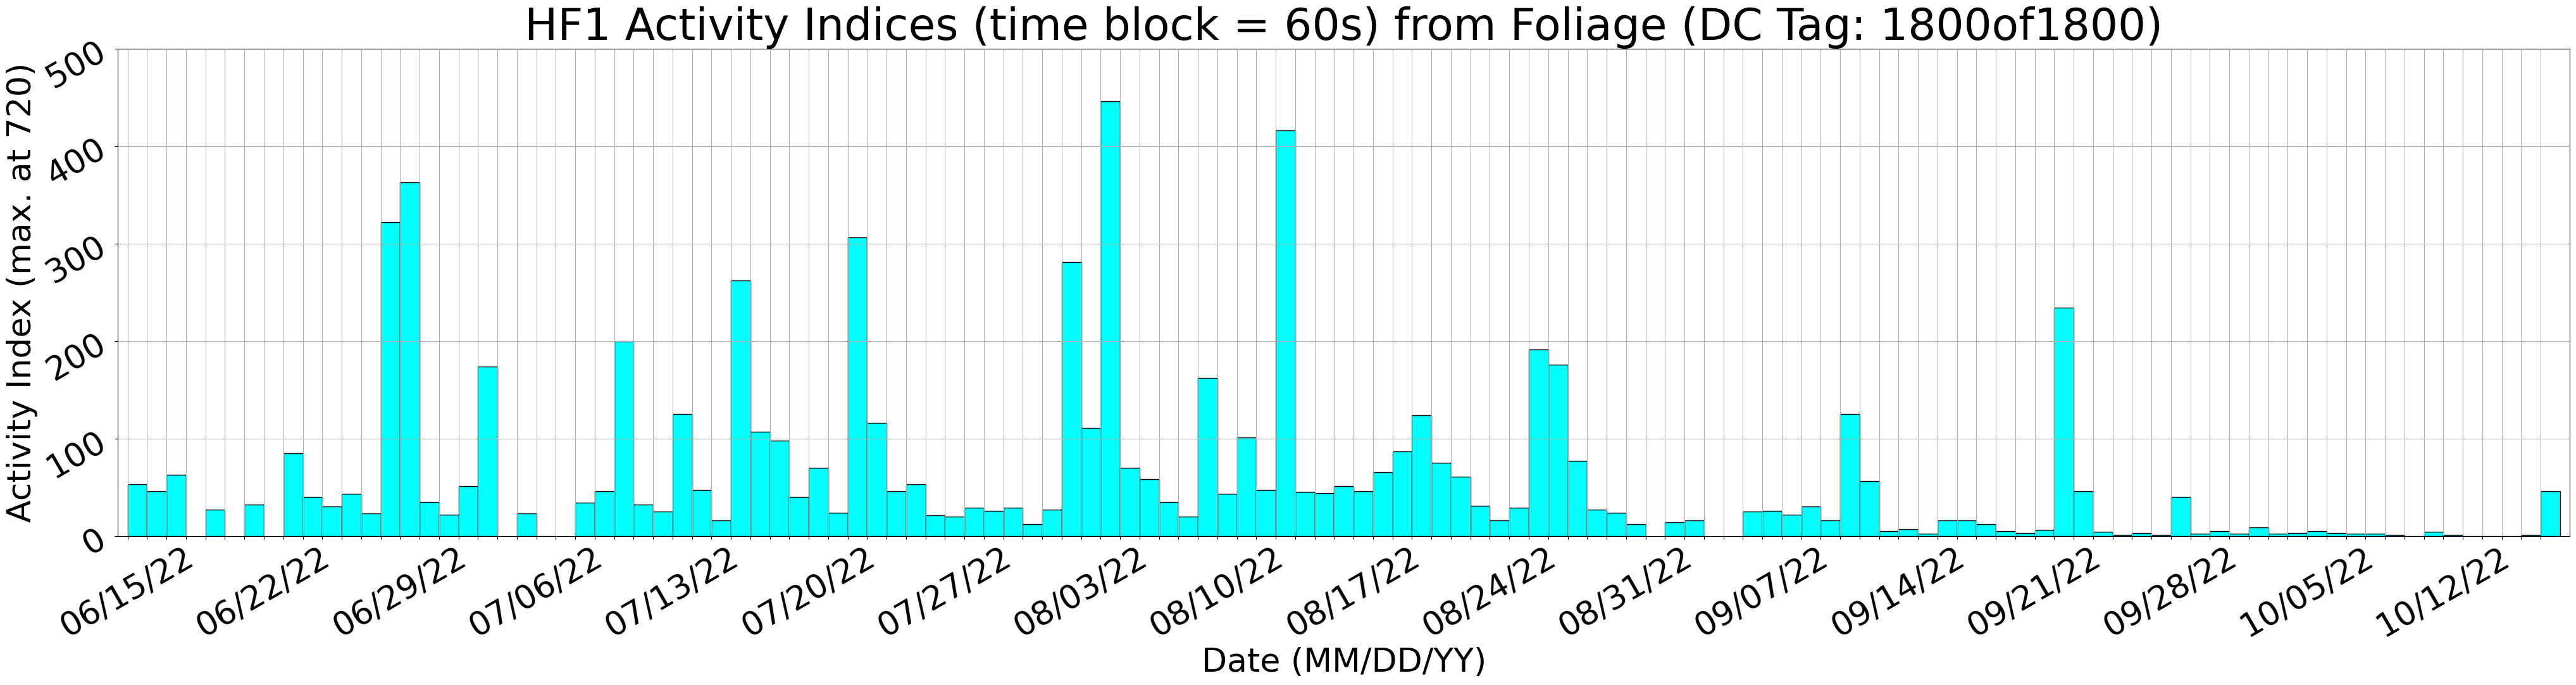

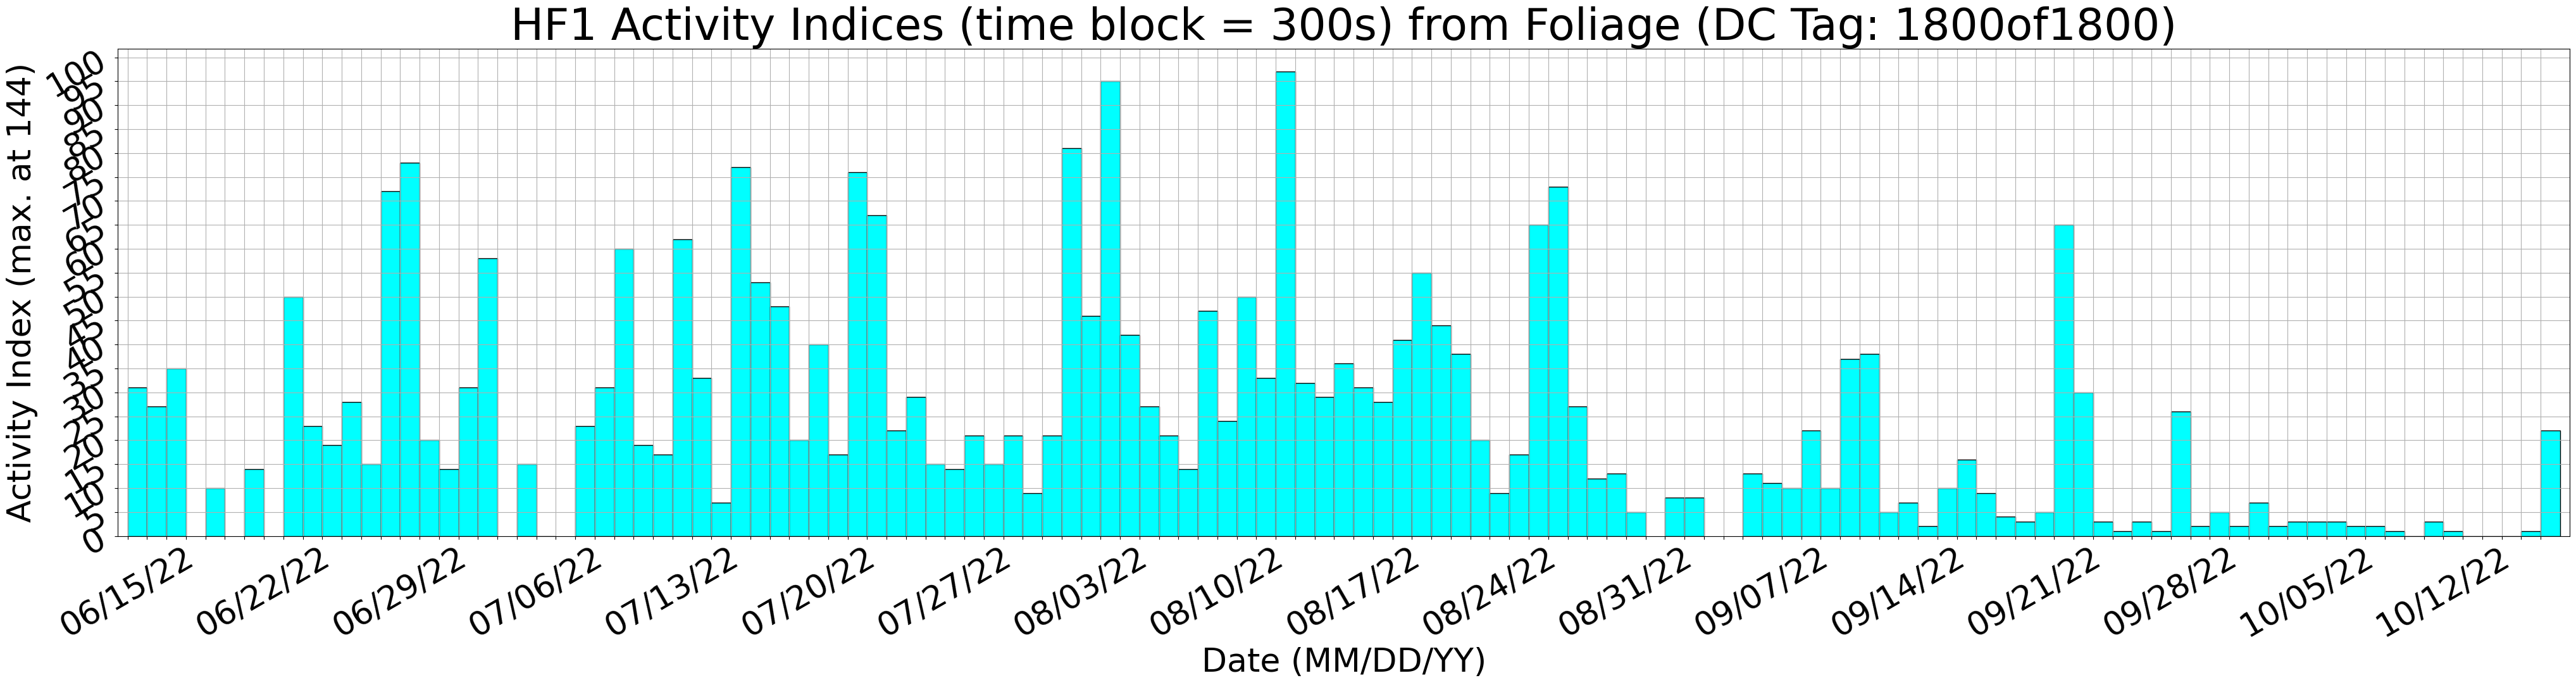

Foliage HF2


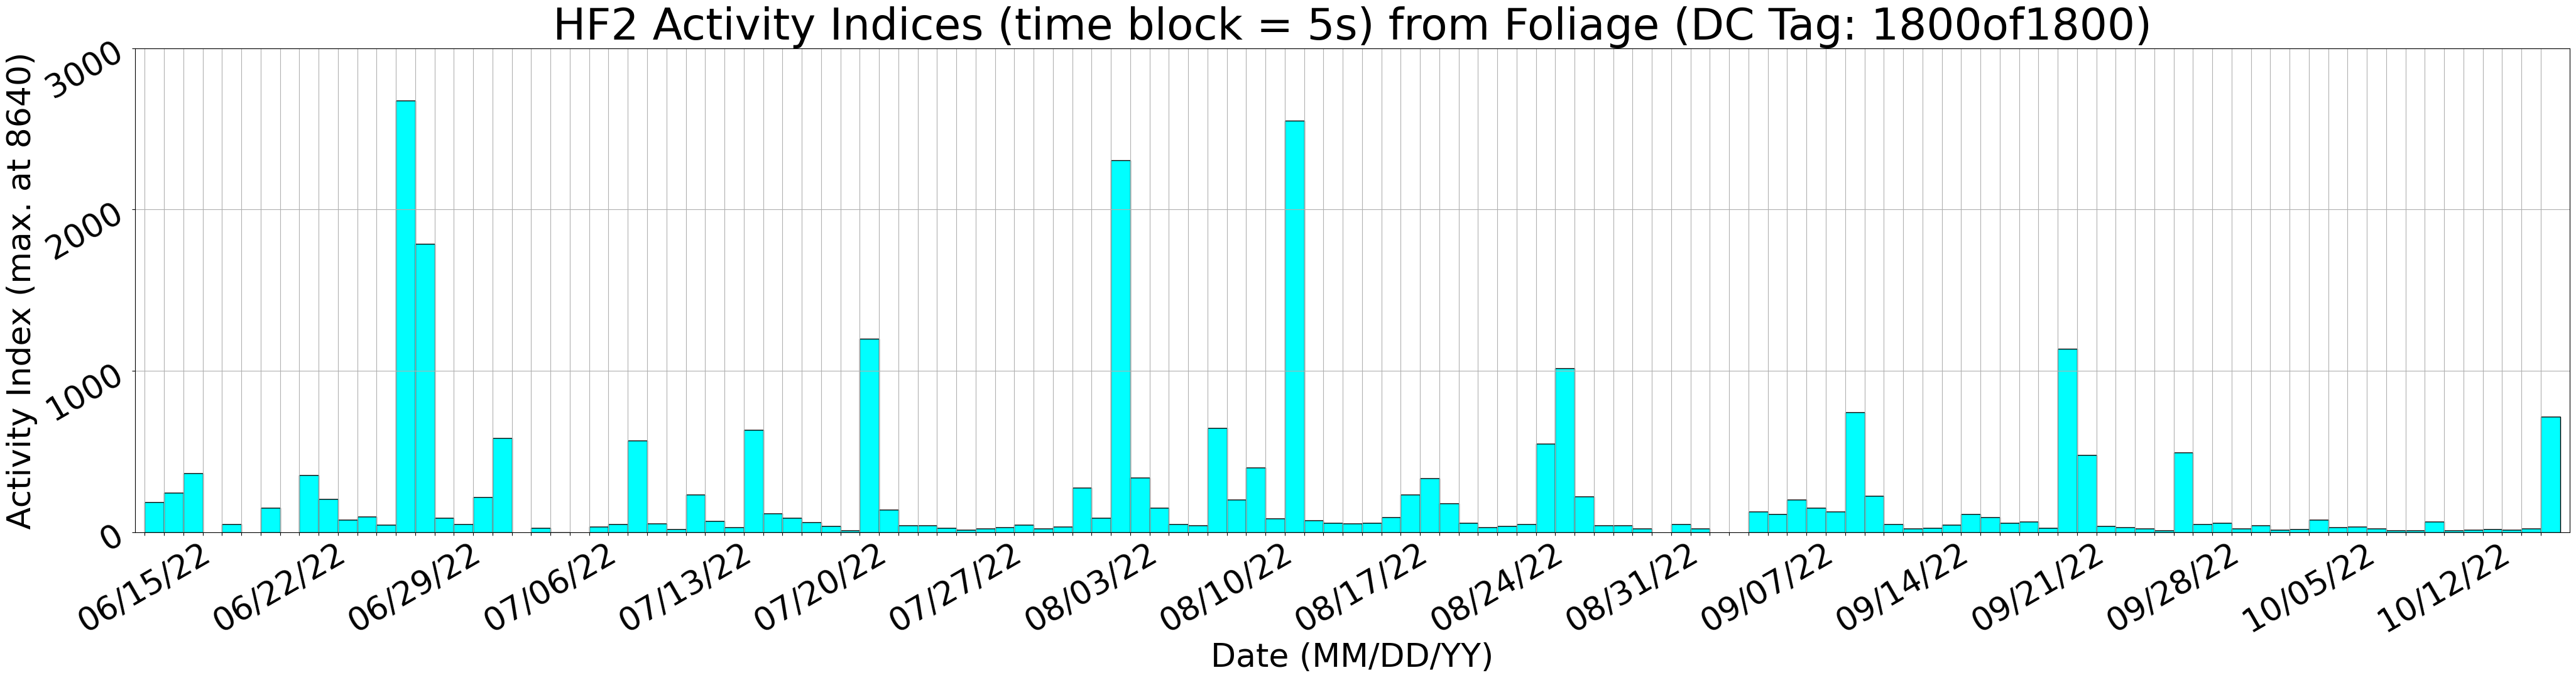

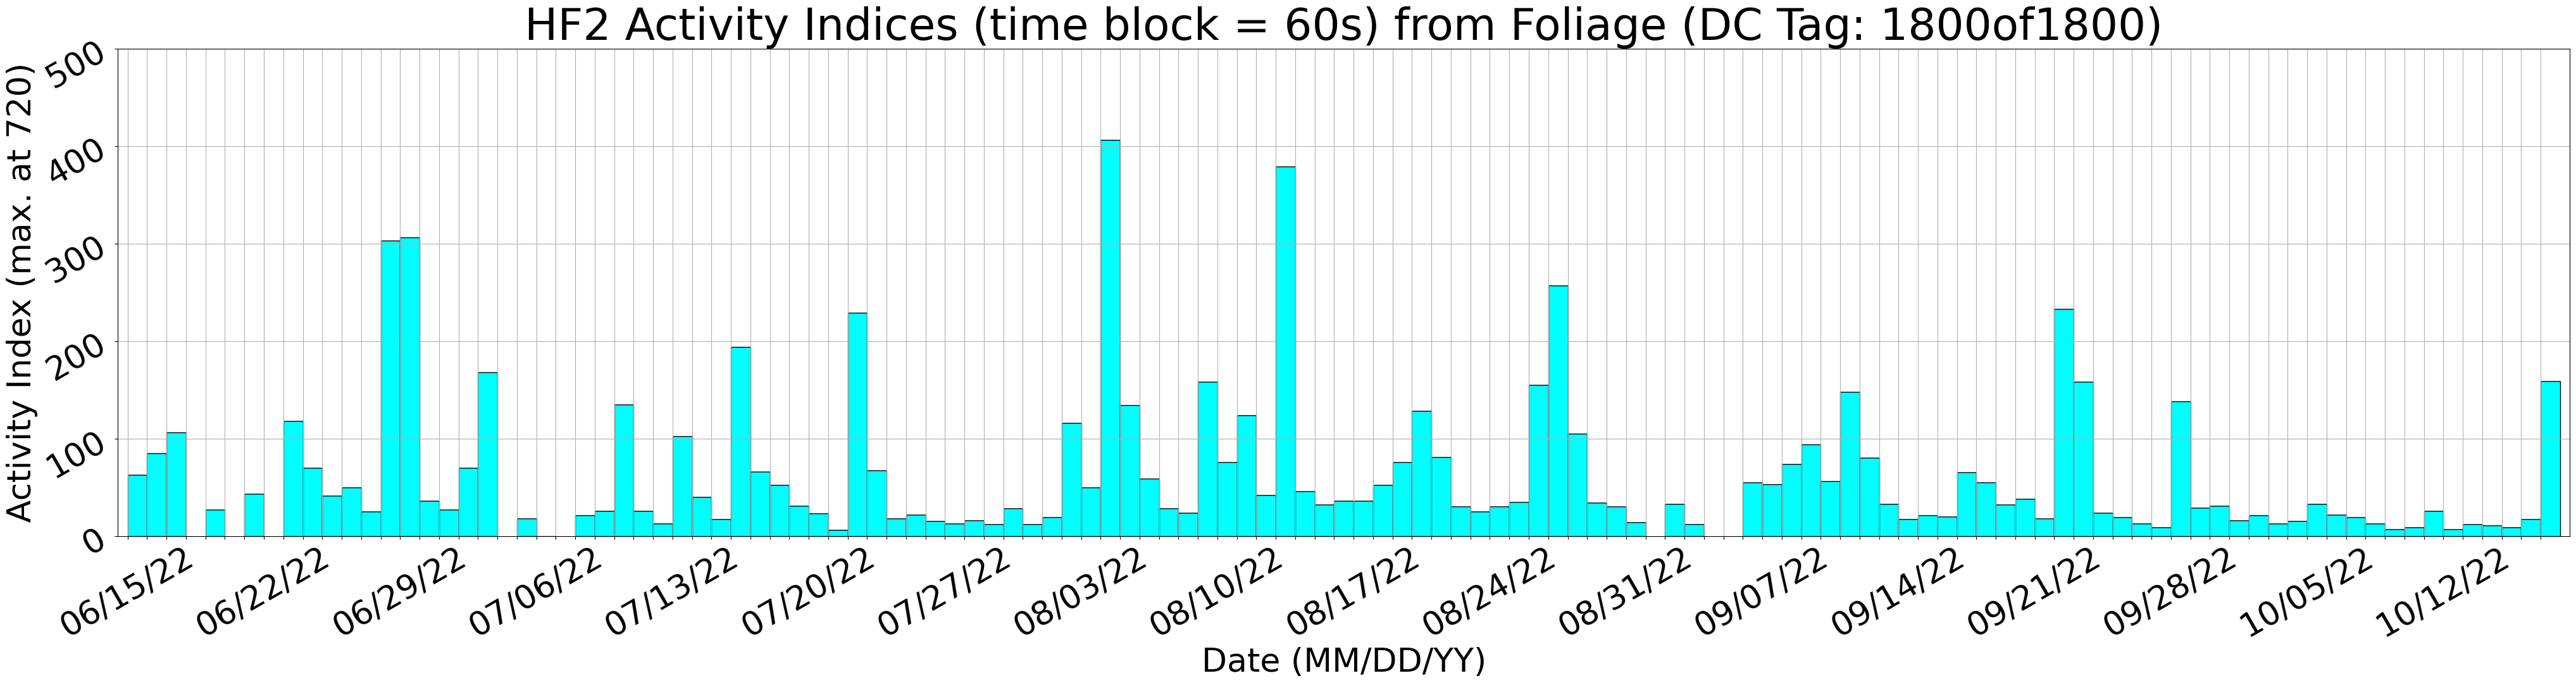

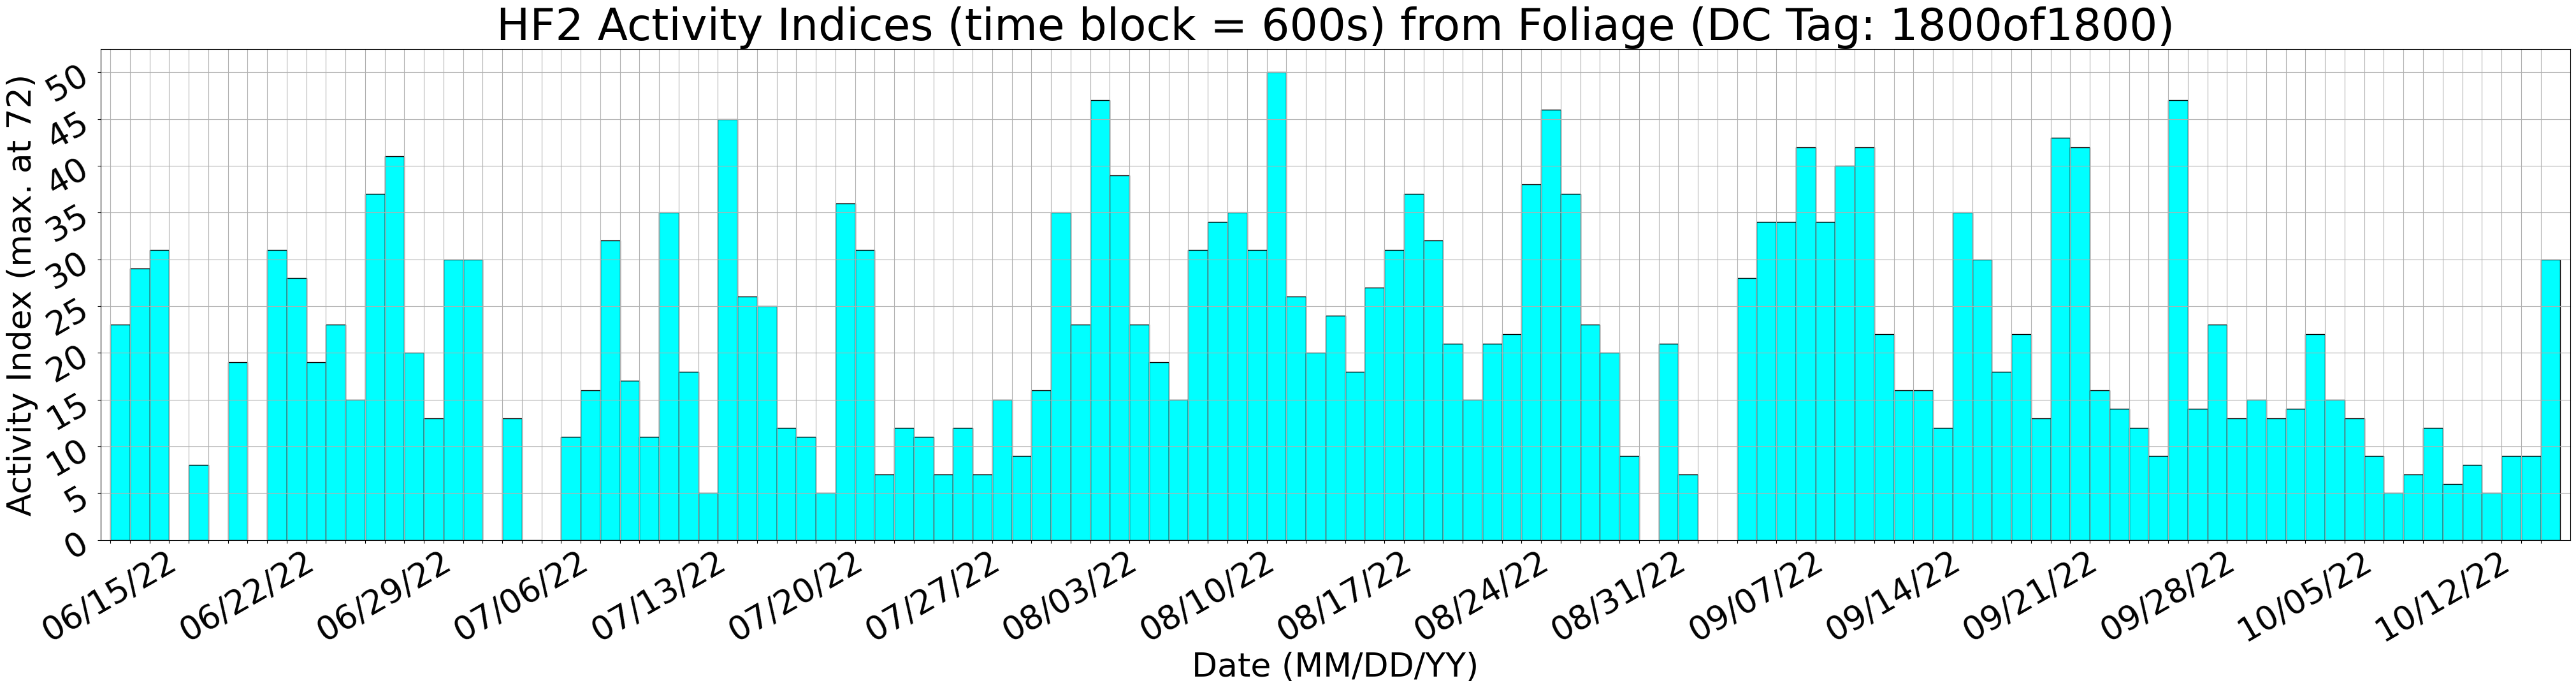

In [6]:
# for site_key in FREQ_GROUPS.keys():
site_keys = ['Carp', 'Foliage']
for site_key in site_keys:
    for type_key in FREQ_GROUPS[site_key].keys():
        print(site_key, type_key)
        data_params['recording_start'] = '02:00'
        data_params['recording_end'] = '13:30'
        data_params["site_name"] = SITE_NAMES[site_key]
        data_params["site_tag"] = site_key
        data_params["type_tag"] = type_key

        file_paths = get_file_paths(data_params)

        activity_bouts_arr = pd.DataFrame()
        location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, data_params['cur_dc_tag'])
        bout_metrics = bt_clustering.generate_bout_metrics_for_location_and_freq(location_df, data_params, data_params['cur_dc_tag'])
        dc_bouts = construct_activity_arr_from_bout_metrics(bout_metrics, data_params, file_paths, data_params['cur_dc_tag'])
        dc_bouts = dc_bouts.set_index("Date_and_Time_UTC")
        activity_bouts_arr = pd.concat([activity_bouts_arr, dc_bouts], axis=1)

        dates = len(activity_bouts_arr.index)
        plt.rcParams.update({'font.size': (0.3*(dates))})
        plt.figure(figsize=(0.4*(dates), 10))
        title = f"{data_params['type_tag']} Bout Percentage from {data_params['site_name']} (DC Tag: {data_params['cur_dc_tag']})"
        plt.title(title, fontsize=0.4*(dates))
        activity_bouts_df = dh.construct_activity_grid_for_bouts(activity_bouts_arr, data_params["cur_dc_tag"])

        activity_dates = pd.DatetimeIndex(activity_bouts_df.columns).strftime("%m/%d/%y")
        plot_dates = [''] * len(activity_dates)
        plot_dates[::7] = activity_dates[::7]

        on = int(data_params['cur_dc_tag'].split('of')[0])
        total = int(data_params['cur_dc_tag'].split('of')[1])
        recover_ratio = total / on
        plt.bar(x=np.arange(0, len(activity_bouts_df.columns)), height=((recover_ratio*activity_bouts_df.values[0])), 
                width=1, edgecolor='k', facecolor=DC_COLOR_MAPPINGS[data_params['cur_dc_tag']])
        plt.xticks(np.arange(0, len(activity_bouts_df.columns))-0.5, plot_dates, rotation=30)
        plt.xlim(-1, len(activity_bouts_df.values[0]))
        plt.ylabel(f'% of time occupied over 12HRS')
        plt.xlabel('Date (MM/DD/YY)')
        plt.grid(which='both')
        plt.show()
        for time_block in time_blocks:
            data_params['index_time_block_in_secs'] = time_block

            activity_inds_arr = pd.DataFrame()
            location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, data_params['cur_dc_tag'])
            dc_dets = construct_activity_indices_arr(location_df, data_params['cur_dc_tag'], file_paths, data_params)
            dc_dets = dc_dets.set_index("Date_and_Time_UTC")
            activity_inds_arr = pd.concat([activity_inds_arr, dc_dets], axis=1)

            dates = len(activity_inds_arr.index)
            plt.rcParams.update({'font.size': (0.3*(dates))})
            plt.figure(figsize=(0.4*(dates), 10))
            time_block_duration = int(data_params['index_time_block_in_secs'])
            peak_index = (60*int(data_params['data_resolution_in_min'])/time_block_duration)
            title = f"{data_params['type_tag']} Activity Indices (time block = {time_block_duration}s) from {data_params['site_name']} (DC Tag: {data_params['cur_dc_tag']})"
            plt.title(title, fontsize=0.4*(dates))
            activity_df = dh.construct_activity_grid_for_inds(activity_inds_arr, data_params["cur_dc_tag"])

            activity_dates = pd.DatetimeIndex(activity_df.columns).strftime("%m/%d/%y")
            plot_dates = [''] * len(activity_dates)
            plot_dates[::7] = activity_dates[::7]

            on = int(data_params['cur_dc_tag'].split('of')[0])
            total = int(data_params['cur_dc_tag'].split('of')[1])
            recover_ratio = total / on
            activity_bars = np.array(recover_ratio*activity_df.values[0])
            plt.bar(x=np.arange(0, len(activity_df.columns)), height=(activity_bars), 
                    width=1, edgecolor='k', facecolor=DC_COLOR_MAPPINGS[data_params['cur_dc_tag']])
            plt.xticks(np.arange(0, len(activity_df.columns))-0.5, plot_dates, rotation=30)
            step = int(10**(np.floor(np.log10(np.nanmax(activity_bars)-0.5))))
            if np.nanmax(activity_bars) <= 200:
                step = 10
            if np.nanmax(activity_bars) <= 100:
                step = 5
            if np.nanmax(activity_bars) <= 20:
                step = 2
            plot_indices = np.arange(0, np.nanmax(activity_bars)+ step, step).astype('int')

            plt.yticks(plot_indices, plot_indices, rotation=30)
            plt.xlim(-1, len(activity_df.values[0]))
            plt.ylabel(f'Activity Index (max. at {int(peak_index)})')
            plt.xlabel('Date (MM/DD/YY)')
            plt.grid(which='both')
            plt.show()

In [7]:
site_key = 'Foliage'
type_key = 'HF2'
print(site_key, type_key)
# for time_block in time_blocks:
time_block = '5'
data_params['index_time_block_in_secs'] = time_block
data_params['recording_start'] = '03:00'
data_params['recording_end'] = '13:30'
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key

file_paths = get_file_paths(data_params)


Foliage HF2


In [8]:
activity_inds_arr = ss.construct_activity_inds_arr_from_dc_tags(data_params, file_paths)

KeyError: 'resolution_in_min'

In [ ]:
def construct_activity_arr_from_bout_metrics(bout_metrics, data_params, file_paths, dc_tag):

    first_call_time = bout_metrics.resample(f'{data_params["data_resolution_in_min"]}T', on='start_time_of_bout', origin='start')['start_time_of_bout'].count().index[0]
    start_of_recording = pd.Timedelta(f"{data_params['recording_start']}:00")
    offset_time = pd.Timedelta(f'{((first_call_time - start_of_recording).time())}') * -1

    all_processed_filepaths = sorted(list(map(str, list(Path(f'{file_paths["raw_SITE_folder"]}').glob('*.csv')))))
    all_processed_datetimes = pd.to_datetime(all_processed_filepaths, format="%Y%m%d_%H%M%S", exact=False)

    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bout_metrics['total_bout_duration_in_secs'] = bout_metrics['bout_duration_in_secs']
    bout_metrics = bout_metrics.set_index('ref_time')

    bout_duration_per_interval = bout_metrics.resample(f"{data_params['data_resolution_in_min']}T", origin='start', offset=offset_time)['total_bout_duration_in_secs'].sum()

    time_occupied_by_bouts  = bout_duration_per_interval.values
    percent_time_occupied_by_bouts = (100*(time_occupied_by_bouts / (60*float(data_params['data_resolution_in_min']))))
    dh.test_bout_percentages_less_than_100(percent_time_occupied_by_bouts)

    bout_duration_per_interval.index = bout_duration_per_interval.index.round('30T')
    bout_dpi_df = pd.DataFrame(list(zip(bout_duration_per_interval.index, percent_time_occupied_by_bouts)), columns=['ref_time', f'percentage_time_occupied_by_bouts ({dc_tag})'])
    bout_dpi_df = bout_dpi_df.set_index('ref_time')
    bout_dpi_df = bout_dpi_df.reindex(index=all_processed_datetimes, fill_value=0)
    bout_dpi_df = bout_dpi_df.resample(f"{data_params['data_resolution_in_min']}T", origin='start').first()
    bout_dpi_df = bout_dpi_df.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    return pd.DataFrame(list(zip(bout_dpi_df.index, bout_dpi_df[f'percentage_time_occupied_by_bouts ({dc_tag})'].values)), columns=["Date_and_Time_UTC", f'percentage_time_occupied_by_bouts ({dc_tag})'])

In [ ]:
activity_bouts_arr = pd.DataFrame()

# for dc_tag in data_params['dc_tags']:
dc_tag = '1800of1800'
location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
bout_metrics = bt_clustering.generate_bout_metrics_for_location_and_freq(location_df, data_params, dc_tag)

In [ ]:
first_call_time = bout_metrics.resample(f'{data_params["data_resolution_in_min"]}T', on='start_time_of_bout', origin='start')['start_time_of_bout'].count().index[0]
start_of_recording = pd.Timedelta(f"{data_params['recording_start']}:00")
offset_time = pd.Timedelta(f'{((first_call_time - start_of_recording).time())}') * -1

all_processed_filepaths = sorted(list(map(str, list(Path(f'{file_paths["raw_SITE_folder"]}').glob('*.csv')))))
all_processed_datetimes = pd.to_datetime(all_processed_filepaths, format="%Y%m%d_%H%M%S", exact=False)

bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
bout_metrics['total_bout_duration_in_secs'] = bout_metrics['bout_duration_in_secs']
bout_metrics = bout_metrics.set_index('ref_time')

bout_duration_per_interval = bout_metrics.resample(f"{data_params['data_resolution_in_min']}T", origin='start', offset=offset_time)['total_bout_duration_in_secs'].sum()

time_occupied_by_bouts  = bout_duration_per_interval.values
percent_time_occupied_by_bouts = (100*(time_occupied_by_bouts / (60*float(data_params['data_resolution_in_min']))))
dh.test_bout_percentages_less_than_100(percent_time_occupied_by_bouts)

bout_duration_per_interval.index = bout_duration_per_interval.index.round('30T')
bout_dpi_df = pd.DataFrame(list(zip(bout_duration_per_interval.index, percent_time_occupied_by_bouts)), columns=['ref_time', f'percentage_time_occupied_by_bouts ({dc_tag})'])
bout_dpi_df = bout_dpi_df.set_index('ref_time')
bout_dpi_df = bout_dpi_df.reindex(index=all_processed_datetimes, fill_value=0)
bout_dpi_df = bout_dpi_df.resample(f"{data_params['data_resolution_in_min']}T", origin='start').first()
bout_dpi_df = bout_dpi_df.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

dc_bouts = pd.DataFrame(list(zip(bout_dpi_df.index, bout_dpi_df[f'percentage_time_occupied_by_bouts ({dc_tag})'].values)), columns=["Date_and_Time_UTC", f'percentage_time_occupied_by_bouts ({dc_tag})'])
# dc_bouts = dh.construct_activity_arr_from_bout_metrics(bout_metrics, data_params, file_paths, dc_tag)
dc_bouts = dc_bouts.set_index("Date_and_Time_UTC")
activity_bouts_arr = pd.concat([activity_bouts_arr, dc_bouts], axis=1)

In [ ]:
bout_duration_per_interval

ref_time
2022-06-15 03:00:00     255.564999
2022-06-15 15:00:00       0.000000
2022-06-16 03:00:00     268.759898
2022-06-16 15:00:00       0.000000
2022-06-17 03:00:00     476.506594
                          ...     
2022-10-15 03:00:00       7.381700
2022-10-15 15:00:00       6.382200
2022-10-16 03:00:00       8.997500
2022-10-16 15:00:00       1.765000
2022-10-17 03:00:00    1048.003191
Name: total_bout_duration_in_secs, Length: 249, dtype: float64

In [ ]:
activity_bouts_arr

Empty DataFrame
Columns: [percentage_time_occupied_by_bouts (1800of1800)]
Index: []

IndexError: index 0 is out of bounds for axis 0 with size 0

/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages/matplotlib/patches.py:738: RuntimeWarning: invalid value encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)
/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages/matplotlib/transforms.py:2049: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx


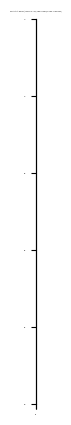

In [ ]:
dates = len(activity_inds_arr.index)
plt.rcParams.update({'font.size': (0.3*(dates))})
plt.figure(figsize=(0.4*(dates), 5))
time_block_duration = int(data_params['index_time_block_in_secs'])
peak_index = (60*int(data_params['data_resolution_in_min'])/time_block_duration)
title = f"{data_params['type_tag']} Activity Indices (time block = {time_block_duration}s) from {data_params['site_name']} (DC Tag: {data_params['cur_dc_tag']})"
plt.title(title, fontsize=0.4*(dates))
activity_inds_df = dh.construct_activity_grid_for_inds(activity_inds_arr, data_params["cur_dc_tag"])

activity_dates = pd.DatetimeIndex(activity_inds_df.columns).strftime("%m/%d/%y")
plot_dates = [''] * len(activity_dates)
plot_dates[::7] = activity_dates[::7]

on = int(data_params['cur_dc_tag'].split('of')[0])
total = int(data_params['cur_dc_tag'].split('of')[1])
recover_ratio = total / on

activity_bars = np.array(recover_ratio*activity_inds_df.values[0])
plt.bar(x=np.arange(0, len(activity_inds_df.columns)), height=(activity_bars), 
        width=1, edgecolor='k', facecolor=DC_COLOR_MAPPINGS[data_params['cur_dc_tag']])
plt.xticks(np.arange(0, len(activity_inds_df.columns))-0.5, plot_dates, rotation=30)
plot_indices = np.arange(0, min(np.nanmax(activity_bars), int(peak_index)), 10).astype('int')

plt.yticks(plot_indices-0.5, plot_indices, rotation=30)
plt.xlim(-1, len(activity_inds_df.values[0]))
plt.ylabel(f'Activity Index')
plt.xlabel('Date (MM/DD/YY)')
plt.grid(which='both')
plt.show()

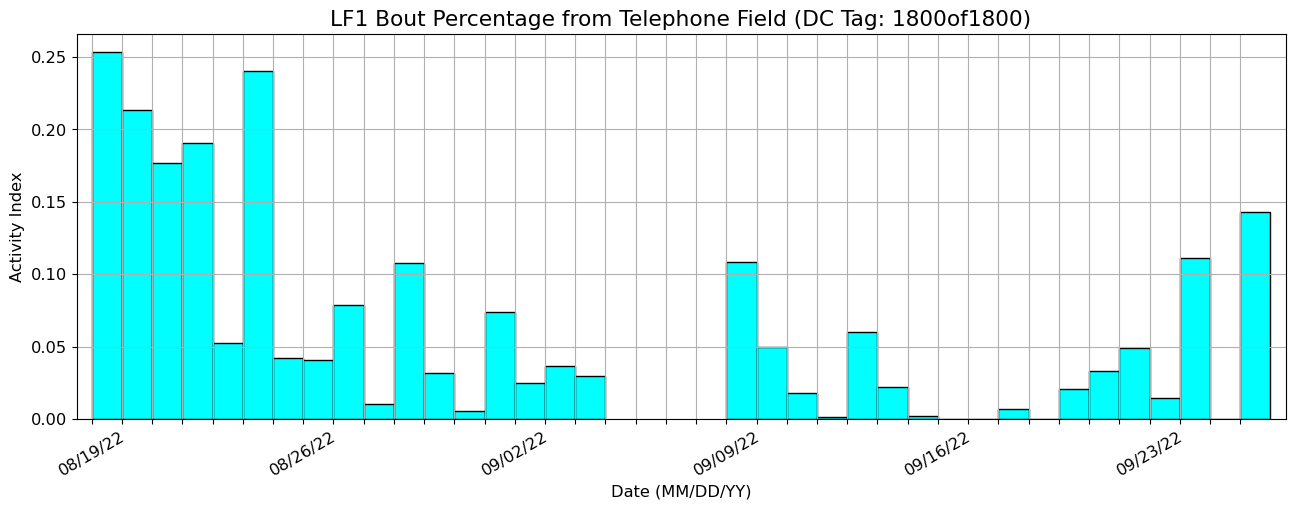

In [ ]:

dates = len(activity_bouts_arr.index)
plt.rcParams.update({'font.size': (0.3*(dates))})
plt.figure(figsize=(0.4*(dates), 5))
title = f"{data_params['type_tag']} Bout Percentage from {data_params['site_name']} (DC Tag: {data_params['cur_dc_tag']})"
plt.title(title, fontsize=0.4*(dates))
activity_bouts_df = dh.construct_activity_grid_for_bouts(activity_bouts_arr, data_params["cur_dc_tag"])

activity_dates = pd.DatetimeIndex(activity_bouts_df.columns).strftime("%m/%d/%y")
plot_dates = [''] * len(activity_dates)
plot_dates[::7] = activity_dates[::7]

on = int(data_params['cur_dc_tag'].split('of')[0])
total = int(data_params['cur_dc_tag'].split('of')[1])
recover_ratio = total / on
plt.bar(x=np.arange(0, len(activity_bouts_df.columns)), height=((recover_ratio*activity_bouts_df.values[0])), 
        width=1, edgecolor='k', facecolor=DC_COLOR_MAPPINGS[data_params['cur_dc_tag']])
plt.xticks(np.arange(0, len(activity_bouts_df.columns))-0.5, plot_dates, rotation=30)
plt.xlim(-1, len(activity_bouts_df.values[0]))
plt.ylabel(f'Activity Index')
plt.xlabel('Date (MM/DD/YY)')
plt.grid(which='both')
plt.show()